<a href="https://colab.research.google.com/github/victorkingbuilder/FlockingHeat/blob/main/Flocking_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess # Import lowess for smoothing
import time # Added for performance timing
from sklearn.metrics import silhouette_score, adjusted_rand_score # Added for clustering evaluation and ARI
from sklearn.metrics import mean_squared_error # Added for MSE calculation
from scipy.stats import entropy, gaussian_kde, shapiro # Added for KL divergence, KDE, and Shapiro-Wilk
from scipy.stats import probplot # Added for Q-Q plot

# New imports for comparing clustering methods
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler # For Z-score normalization in clustering preprocessing
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/My Drive/Swarm_Behavior_Data/'

if os.path.exists(folder_path):
   print("Folder found. Files in the folder:")
   print(os.listdir(folder_path))
else:
   print("Folder not found. Please check the path.")

Folder found. Files in the folder:
['Aligned.csv', 'Flocking.csv', 'Grouped.csv']


In [ ]:
import pandas as pd

try:
    df_aligned = pd.read_csv(os.path.join(folder_path, 'Aligned.csv'))
    df_flocking = pd.read_csv(os.path.join(folder_path, 'Flocking.csv'))
    df_group = pd.read_csv(os.path.join(folder_path, 'Grouped.csv'))

    # --- Add reset_index() here for df_flocking (and potentially others if needed) ---
    df_flocking = df_flocking.reset_index(drop=True)
    # You might want to do this for df_aligned and df_group as well, depending on your needs
    # df_aligned = df_aligned.reset_index(drop=True)
    # df_group = df_group.reset_index(drop=True)
    # --- End of reset_index() ---


    print("\nDatasets loaded successfully and index reset for df_flocking:")
    print("Aligned dataset head:")
    print(df_aligned.head())
    print("\nFlocking dataset head:")
    print(df_flocking.head())
    print("\nGroup dataset head:")
    print(df_group.head())

except FileNotFoundError:
    print("Error: One or more of the CSV files were not found. Check the file names and path.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

# ... (continue with the rest of your data cleaning and analysis) ...

<ipython-input-5-8106dff120fe>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flocking = pd.read_csv(os.path.join(folder_path, 'Flocking.csv'))



Datasets loaded successfully and index reset for df_flocking:
Aligned dataset head:
        x1      y1  xVel1  yVel1   xA1  yA1     xS1     yS1   xC1   yC1  ...  \
0 -1414.14 -535.22 -17.88  -7.23  0.00  0.0    0.00    0.00  0.00  0.00  ...   
1 -1412.93  597.54 -13.55  -5.48  0.00  0.0    0.00    0.00  0.00  0.00  ...   
2 -1407.38   70.72 -14.37  -5.81  0.00  0.0    0.00    0.00  0.00  0.00  ...   
3 -1407.00 -759.80  -7.59  -1.27 -0.98 -0.2    0.00    0.00  0.91  0.41  ...   
4 -1406.36  698.39 -16.54  -6.95 -1.00  0.0 -944.07 -396.62  0.00  0.00  ...   

   yVel200  xA200  yA200  xS200  yS200  xC200  yC200  nAC200  nS200  Class  
0   -16.85    0.0   0.00    0.0    0.0   0.00   0.00      29      0      0  
1   -12.09    0.0   0.00    0.0    0.0   0.00   0.00      44      0      0  
2   -16.20    0.0   0.00    0.0    0.0   0.00   0.00      40      0      0  
3     2.99   -1.0  -0.07    0.0    0.0  -0.52   0.86       3      0      1  
4   -12.61    0.0  -1.00    0.0    0.0   0.00   0

In [ ]:
# Explore the columns of each dataframe
print("Columns in df_aligned:")
print(df_aligned.columns)

print("\nColumns in df_flocking:")
print(df_flocking.columns)

print("\nColumns in df_group:")
print(df_group.columns)

Columns in df_aligned:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class'],
      dtype='object', length=2401)

Columns in df_flocking:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class '],
      dtype='object', length=2401)

Columns in df_group:
Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200', 'yC200',
       'nAC200', 'nS200', 'Class'],
      dtype='object', length=2401)


In [ ]:
print(df_flocking['x1'].dtypes)
print(df_flocking['x1'].unique())
df_flocking['x1'] = pd.to_numeric(df_flocking['x1'], errors='coerce')
df_flocking.dropna(subset=['x1'], inplace=True)

object
[-1414.14 -1412.93 -1407.38 ... '1404.61' '1406.08' ' ']


In [ ]:
print("\nDescriptive statistics for df_flocking:")
print(df_flocking.describe())


Descriptive statistics for df_flocking:
                 x1            y1         xVel1         yVel1           xA1  \
count  24015.000000  24015.000000  24015.000000  24015.000000  24015.000000   
mean     108.280413    -73.075164     -0.737349      0.041626     -0.148095   
std      842.179950    572.563956      6.445383      7.374829      0.377036   
min    -1414.140000  -1012.180000    -18.590000    -18.410000     -1.000000   
25%     -539.665000   -609.365000     -5.520000     -5.710000     -0.230000   
50%      156.010000   -156.710000     -0.460000     -1.600000      0.000000   
75%      898.135000    424.460000      3.820000      7.310000      0.000000   
max     1406.080000   1015.800000     18.470000     18.630000      1.000000   

                yA1           xS1           yS1           xC1           yC1  \
count  24015.000000  24015.000000  24015.000000  24015.000000  24015.000000   
mean       0.150991     -1.217259     -0.835834     -0.035582      0.075811   
std       

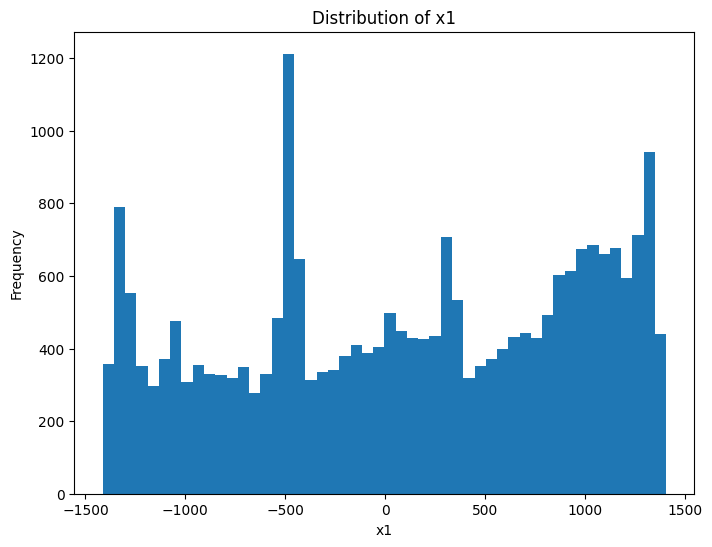

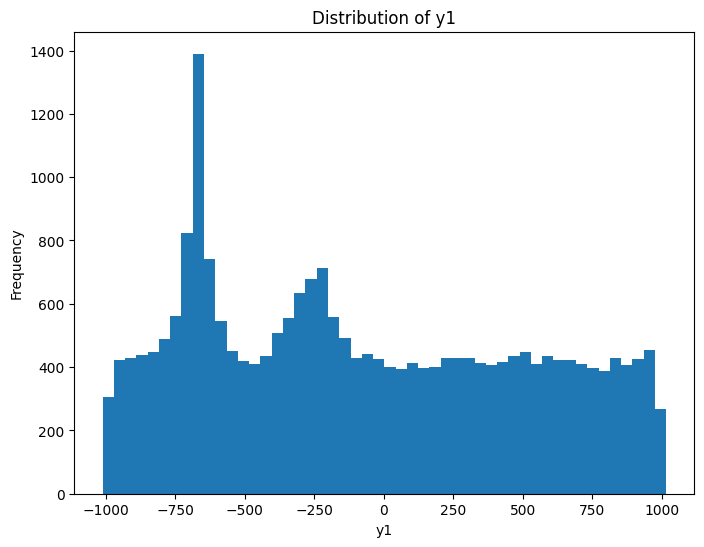

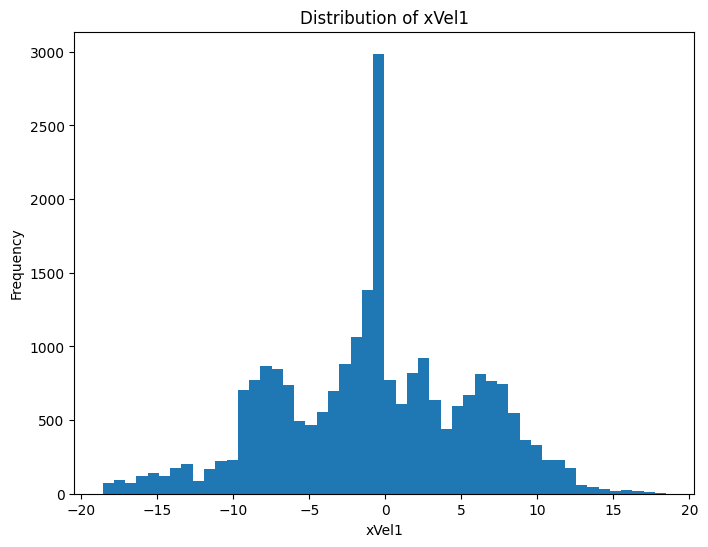

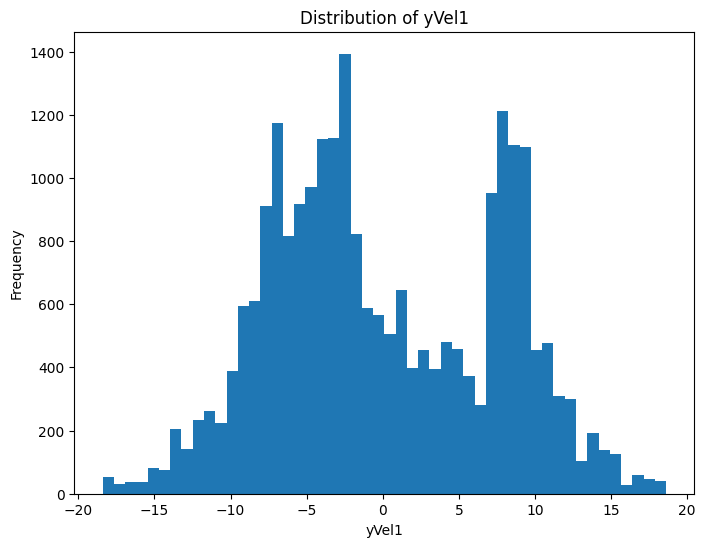

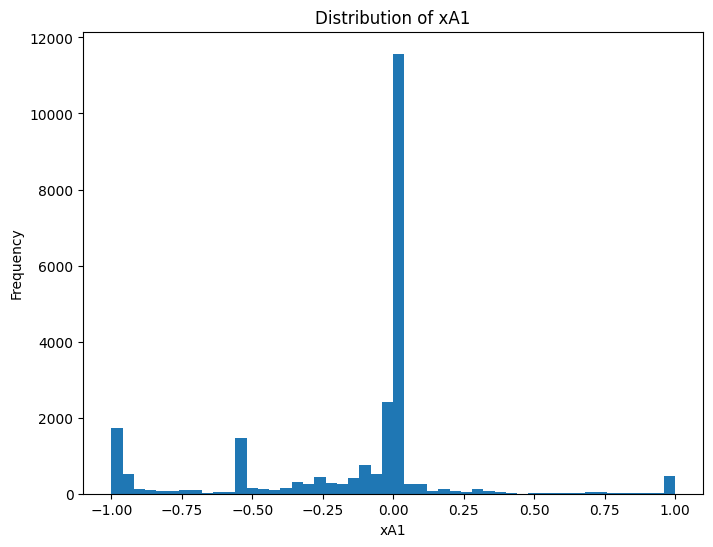

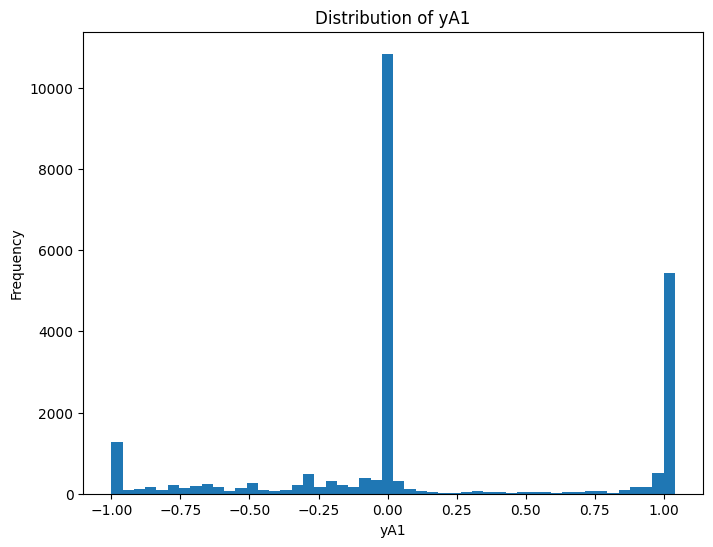

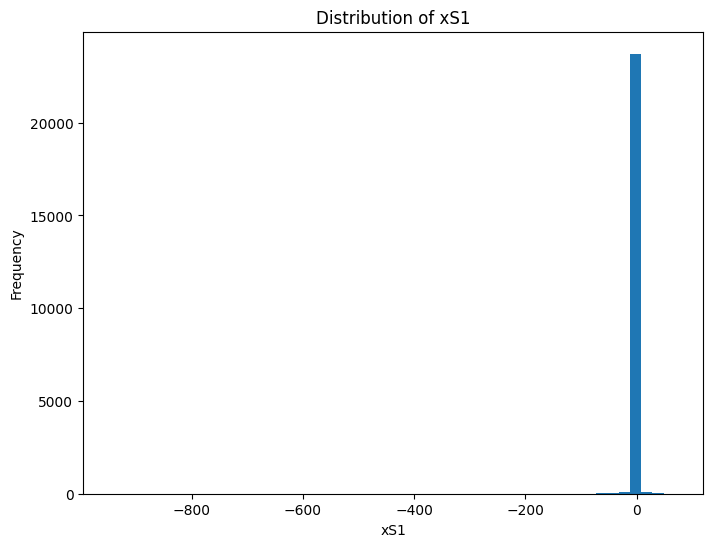

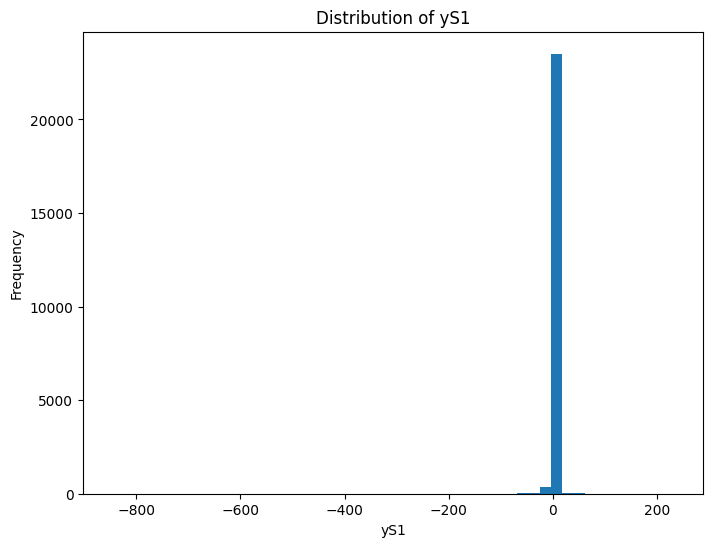

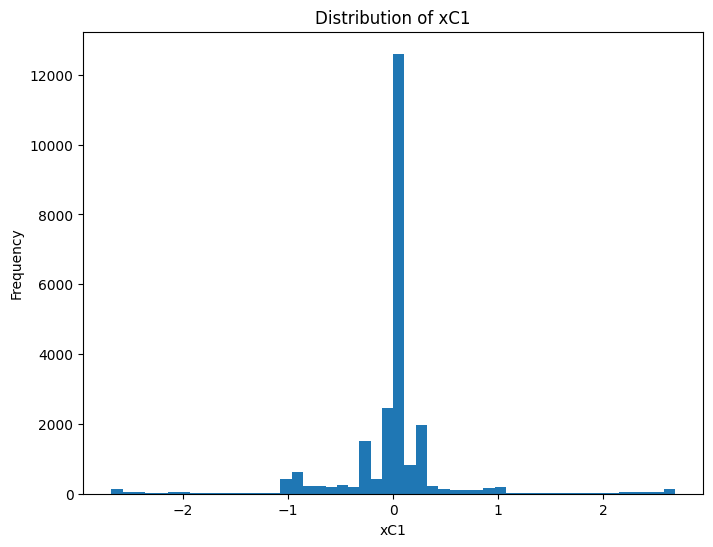

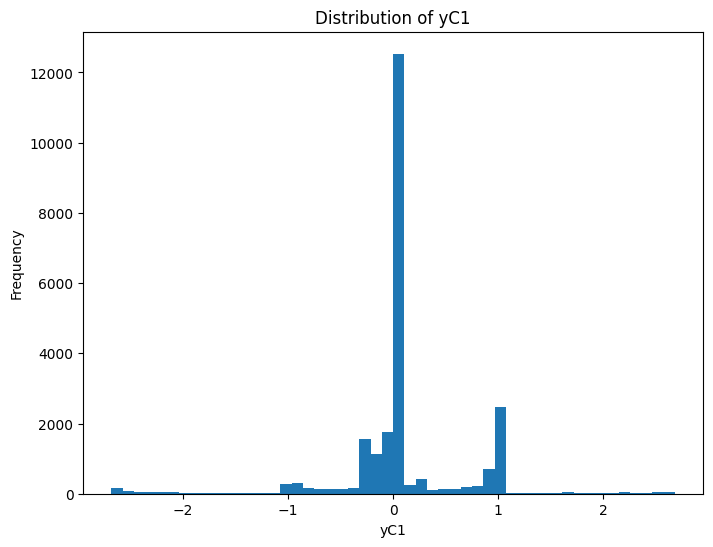

In [ ]:
import matplotlib.pyplot as plt

# Choose a few columns you think are relevant to positions, velocities, or distances
# Replace 'column_name_1', 'column_name_2', etc. with actual column names from df_flocking
columns_to_visualize = ['x1','y1','xVel1', 'yVel1','xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1'] # Add more column names here

for col in columns_to_visualize:
    if col in df_flocking.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_flocking[col], bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Column '{col}' not found in df_flocking.")

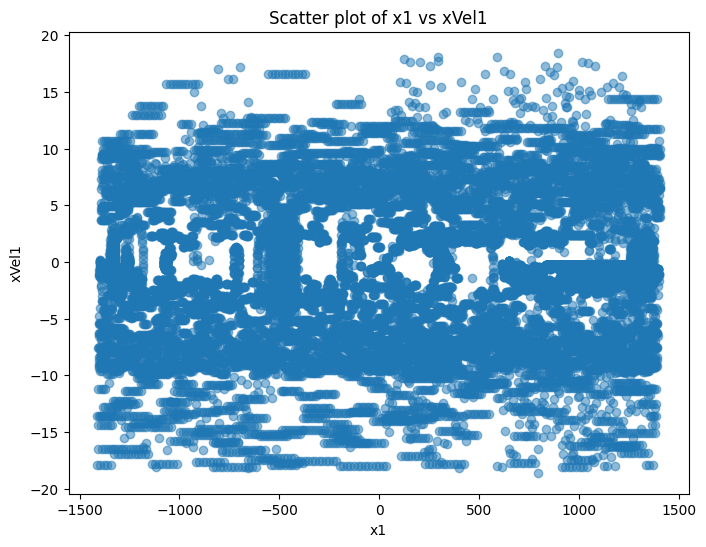

In [ ]:
# Choose two columns to plot against each other
# Replace 'feature_1' and 'feature_2' with actual column names from df_flocking
feature_1 = 'x1'
feature_2 = 'xVel1'

if feature_1 in df_flocking.columns and feature_2 in df_flocking.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_flocking[feature_1], df_flocking[feature_2], alpha=0.5)
    plt.title(f'Scatter plot of {feature_1} vs {feature_2}')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.show()
else:
    print(f"One or both columns '{feature_1}' and '{feature_2}' not found in df_flocking.")

## 1. Average Velocity of the Swarm:
To calculate the average velocity of the swarm at each time step, we took the average of the x and y velocity components across all agents.

In [ ]:
# Assuming velocity columns are named xVel1, yVel1, xVel2, yVel2, etc.
# You'll need to adapt this if your column names are different or you have a different number of agents

# Select all columns that represent x and y velocities
x_vel_cols = [col for col in df_flocking.columns if 'xVel' in col]
y_vel_cols = [col for col in df_flocking.columns if 'yVel' in col]

# Calculate the average x and y velocity across all agents
df_flocking['avg_x_velocity'] = df_flocking[x_vel_cols].mean(axis=1)
df_flocking['avg_y_velocity'] = df_flocking[y_vel_cols].mean(axis=1)

# Calculate the magnitude of the average velocity
df_flocking['avg_velocity_magnitude'] = np.sqrt(df_flocking['avg_x_velocity']**2 + df_flocking['avg_y_velocity']**2)

print("\nAverage velocity columns added to df_flocking:")
print(df_flocking[['avg_x_velocity', 'avg_y_velocity', 'avg_velocity_magnitude']].head())


Average velocity columns added to df_flocking:
   avg_x_velocity  avg_y_velocity  avg_velocity_magnitude
0        -3.14935        -7.72905                8.346054
1        -3.28055        -7.73925                8.405831
2        -2.86450        -7.24115                7.787144
3        -6.41290        -0.66785                6.447582
4        -3.52935        -6.26410                7.189942


## 2. Average Distance Between Agents:
We calculated the average distance by first calculating the average distance of each agent to the center of the swarm.

First, let's calculate the center of the swarm (average x and y position).

In [ ]:
# Since our position columns are named x1, y1, x2, y2, etc. You'll need to adapt

# Select all columns that represent x and y positions
x_pos_cols = [col for col in df_flocking.columns if col.startswith('x') and col[1:].isdigit()]
y_pos_cols = [col for col in df_flocking.columns if col.startswith('y') and col[1:].isdigit()]


# Calculate the average x and y position across all agents (center of the swarm)
df_flocking['swarm_center_x'] = df_flocking[x_pos_cols].mean(axis=1)
df_flocking['swarm_center_y'] = df_flocking[y_pos_cols].mean(axis=1)

# Now, calculate the distance of each agent to the swarm center and then average
distances_to_center = []
for i in range(1, 201): # Assuming up to 200 agents
    x_col = f'x{i}'
    y_col = f'y{i}'
    if x_col in df_flocking.columns and y_col in df_flocking.columns:
        distance = np.sqrt((df_flocking[x_col] - df_flocking['swarm_center_x'])**2 + (df_flocking[y_col] - df_flocking['swarm_center_y'])**2)
        distances_to_center.append(distance)

# Calculate the average distance to the center across all agents
df_flocking['avg_distance_to_center'] = pd.concat(distances_to_center, axis=1).mean(axis=1)

print("\nAverage distance to center column added to df_flocking:")
print(df_flocking[['swarm_center_x', 'swarm_center_y', 'avg_distance_to_center']].head())


Average distance to center column added to df_flocking:
   swarm_center_x  swarm_center_y  avg_distance_to_center
0        57.40820       -34.12215              942.503578
1       -39.07540       -67.15180              953.482680
2         3.66115        36.63670              912.604185
3       122.77625        54.35525              935.923303
4        77.15310        12.23910              929.381731


## 3. Average Alignment

In [ ]:
# 1. Calculate headings and cosines in separate DataFrames
heading_data = {}
cos_heading_data = {}

for i in range(1, 201): # Assuming up to 200 agents
    x_vel_col = f'xVel{i}'
    y_vel_col = f'yVel{i}'
    if x_vel_col in df_flocking.columns and y_vel_col in df_flocking.columns:
        heading_data[f'heading_{i}'] = np.arctan2(df_flocking[y_vel_col], df_flocking[x_vel_col])
        cos_heading_data[f'cos_heading_{i}'] = np.cos(heading_data[f'heading_{i}'])

# Convert dictionaries to DataFrames
headings_df = pd.DataFrame(heading_data)
cos_headings_df = pd.DataFrame(cos_heading_data)

# 2. Concatenate the new DataFrames to the original DataFrame
df_flocking = pd.concat([df_flocking, headings_df, cos_headings_df], axis=1)

# 3. Calculate the average cosine of the headings across all agents
heading_cos_cols = [col for col in df_flocking.columns if col.startswith('cos_heading_')]
df_flocking['avg_alignment'] = df_flocking[heading_cos_cols].mean(axis=1)

print("\nAverage alignment column added to df_flocking:")
print(df_flocking[['avg_alignment']].head())


Average alignment column added to df_flocking:
   avg_alignment
0      -0.264251
1      -0.264271
2      -0.264238
3      -0.764597
4      -0.304358


## Explorative Analysis of the New Average Columns

In [ ]:
print("\nDescriptive statistics for aggregate swarm features:")
print(df_flocking[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].describe())


Descriptive statistics for aggregate swarm features:
       avg_velocity_magnitude  avg_distance_to_center  avg_alignment
count            24015.000000            24015.000000   24015.000000
mean                 5.818939              873.431710      -0.167521
std                  2.802965              109.143974       0.325980
min                  0.003963              312.513907      -0.983973
25%                  3.636368              832.210950      -0.263027
50%                  6.230279              904.874754      -0.079180
75%                  8.095412              935.477742      -0.001766
max                 11.714667             1396.118340       0.511052


## Visualize Distributions (Histograms)

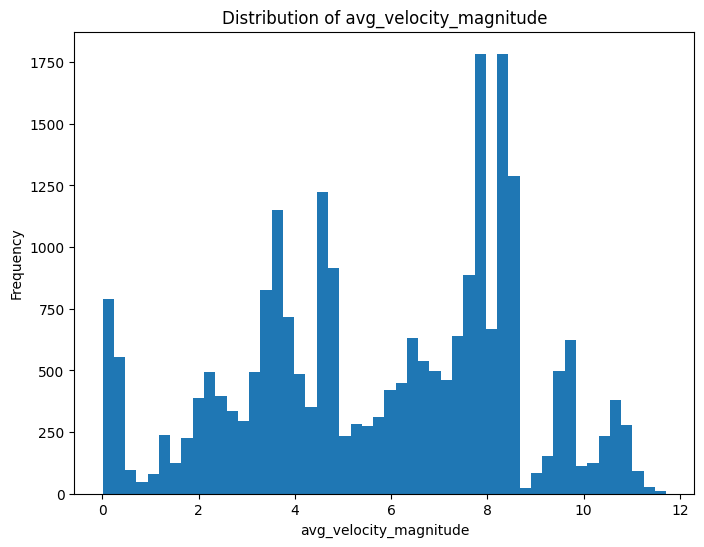

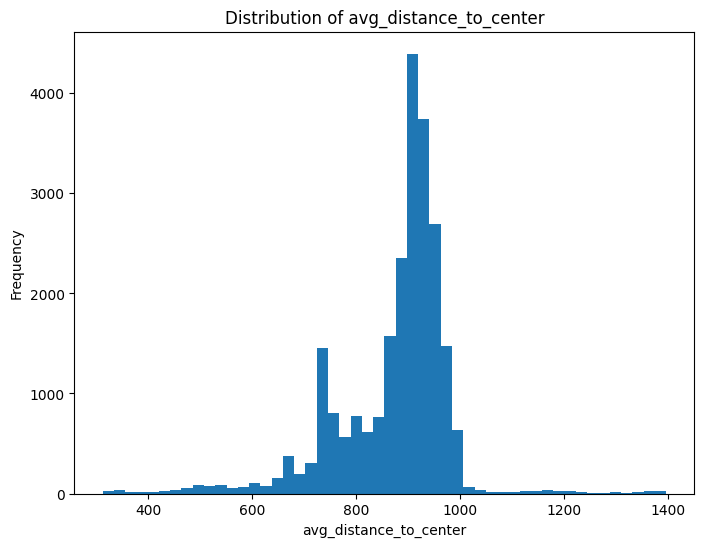

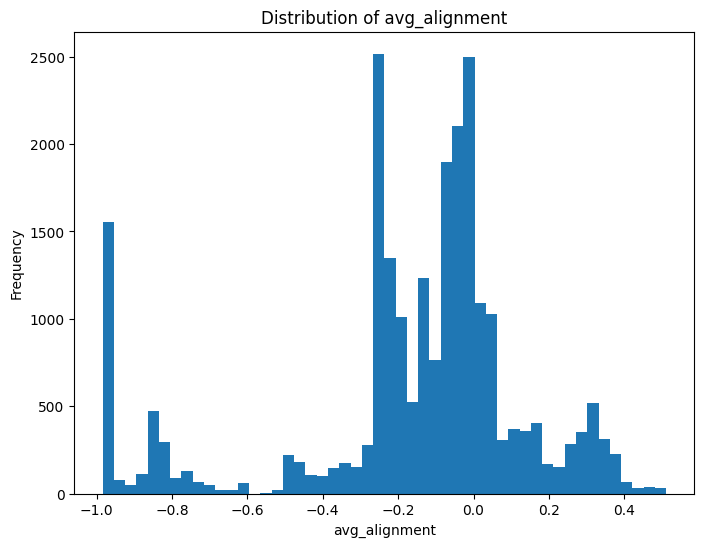

In [ ]:
import matplotlib.pyplot as plt

aggregate_cols_to_visualize = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

for col in aggregate_cols_to_visualize:
    if col in df_flocking.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df_flocking[col], bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Column '{col}' not found in df_flocking.")


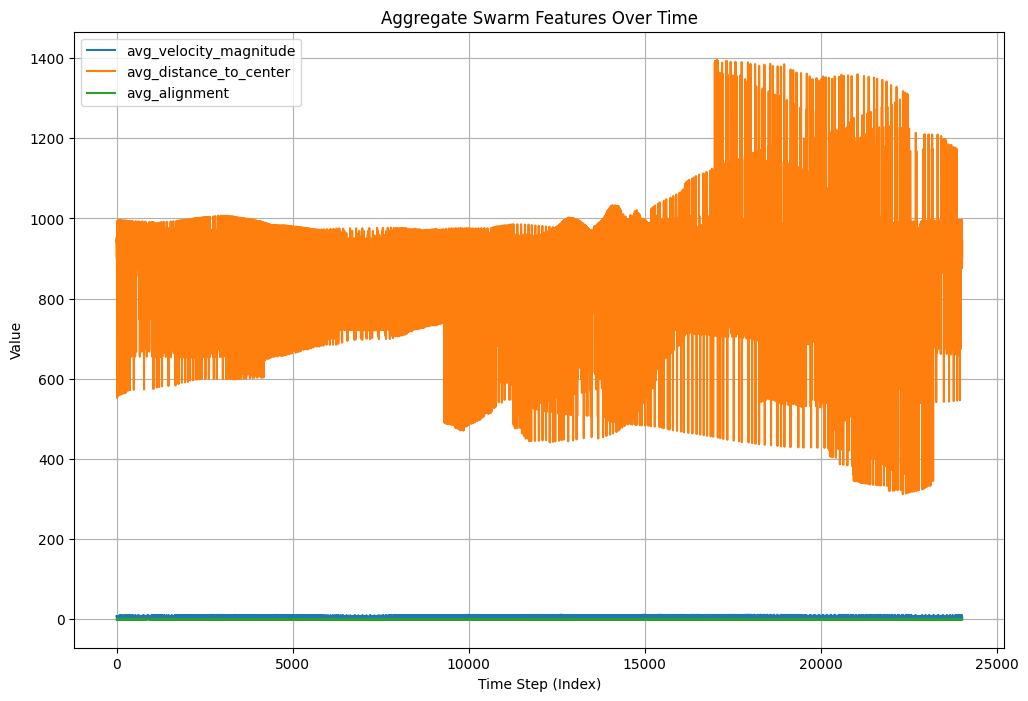

In [ ]:
import matplotlib.pyplot as plt

aggregate_cols_to_plot = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

plt.figure(figsize=(12, 8))
for col in aggregate_cols_to_plot:
    if col in df_flocking.columns:
        plt.plot(df_flocking.index, df_flocking[col], label=col) # Assuming time is represented by the index
    else:
        print(f"Column '{col}' not found in df_flocking.")

plt.title('Aggregate Swarm Features Over Time')
plt.xlabel('Time Step (Index)') # Adjust label if you have a specific time column
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Ensure all arrays have the same length for combination
# Access the columns directly from the DataFrame
min_len = min(len(df_flocking['avg_velocity_magnitude']), len(df_flocking['avg_distance_to_center']), len(df_flocking['avg_alignment']))

data = pd.DataFrame({
    'avg_velocity_magnitude': df_flocking['avg_velocity_magnitude'][:min_len],
    'avg_distance_to_center': df_flocking['avg_distance_to_center'][:min_len],
    'avg_alignment': df_flocking['avg_alignment'][:min_len]
})

print(f"Synthetic data shape: {data.shape}")
print(data.head())

Synthetic data shape: (24015, 3)
   avg_velocity_magnitude  avg_distance_to_center  avg_alignment
0                8.346054              942.503578      -0.264251
1                8.405831              953.482680      -0.264271
2                7.787144              912.604185      -0.264238
3                6.447582              935.923303      -0.764597
4                7.189942              929.381731      -0.304358


In [ ]:
# --- 2. Preprocess Data (Important for GMMs) ---
# It's highly recommended to scale our features, especially if they are on different scales.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)



In [ ]:
# --- 3. Determine Range of Components to Test ---
n_components_range = range(1, 15) # Test from 1 to 14 components

# --- 4. Fit GMMs and Calculate BIC/AIC ---
bic = []
aic = []
lowest_bic = np.inf
best_gmm = None

for n_components in n_components_range:
    # Define a GMM model
    # covariance_type='full' is the default and most flexible
    # max_iter can be increased if convergence issues arise
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)

    # Fit the model to the scaled data
    gmm.fit(X_scaled)

    # Calculate BIC and AIC
    bic.append(gmm.bic(X_scaled))
    aic.append(gmm.aic(X_scaled))

    # Keep track of the best GMM based on BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

print(f"\nOptimal number of components according to BIC: {best_gmm.n_components}")




Optimal number of components according to BIC: 14


In [ ]:
cluster_labels = best_gmm.predict(X_scaled)
data['cluster_label'] = cluster_labels

In [ ]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment
cluster_label                                                               
0                            7.277666              900.597326      -0.824237
1                            3.933459              922.447191      -0.139634
2                            2.699689              660.199957       0.076446
3                            8.899048              926.991113      -0.026827
4                           10.581913              891.401929       0.313331
5                            8.457994              790.054844      -0.032697
6                            0.235559              731.654686       0.010271
7                            6.372496              895.625886      -0.198947
8                            2.058433              924.575542       0.086854
9                            5.498109              508.709524       0.365733
10                       

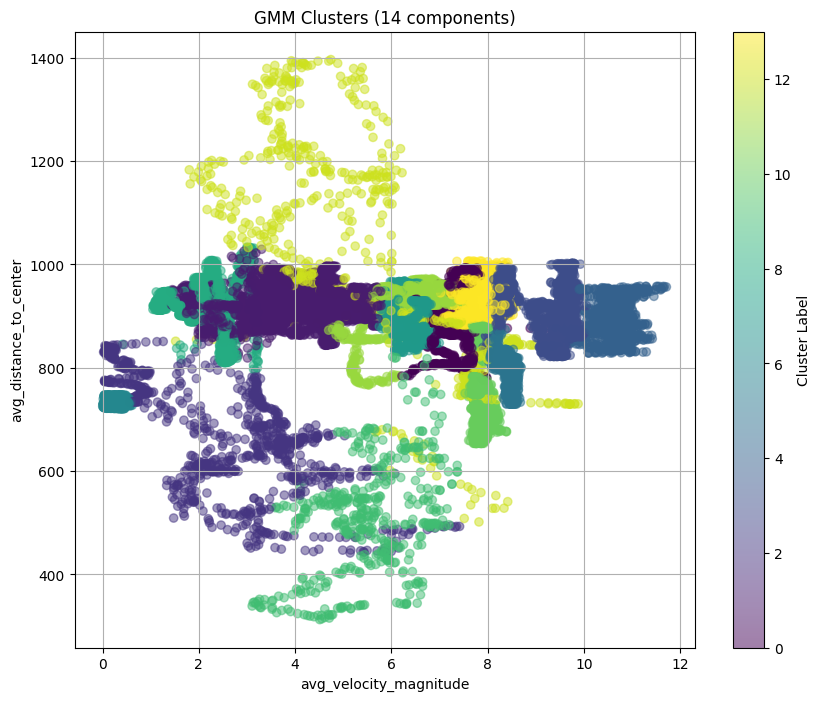

In [ ]:
import matplotlib.pyplot as plt

# You can choose any two of your aggregate features to plot
feature1 = 'avg_velocity_magnitude'
feature2 = 'avg_distance_to_center'

plt.figure(figsize=(10, 8))
plt.scatter(data[feature1], data[feature2], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'GMM Clusters ({best_gmm.n_components} components)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# You can create similar plots for other pairs of features


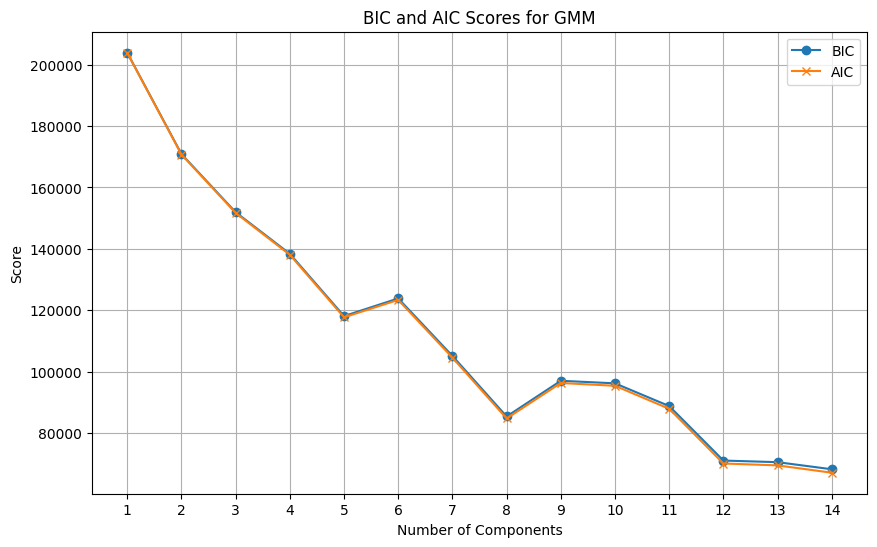


--- Analysis with Best GMM (14 components) ---
Cluster assignments for the first 10 data points:
   avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
0                8.346054              942.503578      -0.264251   
1                8.405831              953.482680      -0.264271   
2                7.787144              912.604185      -0.264238   
3                6.447582              935.923303      -0.764597   
4                7.189942              929.381731      -0.304358   
5                7.680784              900.855275      -0.264283   
6                7.243821              947.852255      -0.856056   
7                4.363400              932.151029      -0.258021   
8                8.340536              919.792465      -0.264272   
9                7.846184              750.083271      -0.974103   

   cluster_label  
0             13  
1             13  
2             13  
3              0  
4             11  
5             13  
6              0  
7

In [ ]:
# --- 5. Visualize BIC and AIC ---
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.plot(n_components_range, aic, marker='x', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for GMM')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Further analysis with the best GMM ---
if best_gmm:
    # Corrected line: use best_gmm.n_components instead of best_gmm.n_components_
    print(f"\n--- Analysis with Best GMM ({best_gmm.n_components} components) ---")
    # Predict clusters for your data
    cluster_labels = best_gmm.predict(X_scaled)
    data['cluster_label'] = cluster_labels
    print("Cluster assignments for the first 10 data points:")
    print(data.head(10)[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment', 'cluster_label']])

    # You can also inspect the means and covariances of the components
    print("\nMeans of the components (scaled features):")
    print(best_gmm.means_)
    print("\nCovariances of the components (first component's covariance matrix):")
    print(best_gmm.covariances_[0]) # Example: print covariance of the first component

    # To get means back to original scale (approximate, more complex for non-diagonal covariance)
    original_scale_means = scaler.inverse_transform(best_gmm.means_)
    print("\nMeans of the components (approx. original scale):")
    print(original_scale_means)

    # You can now analyze the characteristics of each cluster/component
    # For example, mean values of original features for each cluster
    print("\nMean feature values per cluster (original scale):")
    print(data.groupby('cluster_label').mean())

## Analyzing our GMM clusters and exploring potential "thermodynamic" interpretations.
- Analyze the mean features per cluster (which we've already done, but let's look at the output again to interpret it).
- Analyze transitions between clusters over time.
- Calculate a simple measure of "entropy" based on the spatial distribution.

Step 1: Re-examine Mean Feature Values Per Cluster

In [ ]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment
cluster_label                                                               
0                            7.277666              900.597326      -0.824237
1                            3.933459              922.447191      -0.139634
2                            2.699689              660.199957       0.076446
3                            8.899048              926.991113      -0.026827
4                           10.581913              891.401929       0.313331
5                            8.457994              790.054844      -0.032697
6                            0.235559              731.654686       0.010271
7                            6.372496              895.625886      -0.198947
8                            2.058433              924.575542       0.086854
9                            5.498109              508.709524       0.365733
10                       

Step 2: Analyze Transitions Between Clusters

In [ ]:
print("\nSequence of cluster labels over time (first 20 time steps):")
print(data['cluster_label'].head(20))

# You can also calculate the frequency of transitions between clusters
# This involves looking at pairs of consecutive cluster labels
transitions = pd.crosstab(data['cluster_label'].shift(1), data['cluster_label'])
print("\nTransition matrix (from row cluster to column cluster):")
print(transitions)


Sequence of cluster labels over time (first 20 time steps):
0     13
1     13
2     13
3      0
4     11
5     13
6      0
7      1
8     13
9     10
10    13
11     2
12    10
13    11
14    10
15    10
16    11
17    11
18     0
19     7
Name: cluster_label, dtype: int64

Transition matrix (from row cluster to column cluster):
cluster_label   0     1    2     3    4    5    6    7    8    9    10   11  \
cluster_label                                                                 
0.0             72   408   60   138   86   56   27   66   81   11   94   62   
1.0            389  1988  235   523  388  652  137  383  478  122  504  344   
2.0             47   230   86    72   67   10   41   42   55   10   73   49   
3.0            136   547   61  1115  109   44    1  219  122   49  154  117   
4.0             81   394   67   117  102   44   23   72   89   19   82   79   
5.0             53   652   11    34   58  129    0  105   94   81  109   45   
6.0             27   136   37     3 

In [ ]:
transition_probabilities = transitions.div(transitions.sum(axis=1), axis=0)
print("\nNormalized Transition Matrix (Probabilities):")
print(transition_probabilities)


Normalized Transition Matrix (Probabilities):
cluster_label        0         1         2         3         4         5   \
cluster_label                                                               
0.0            0.056872  0.322275  0.047393  0.109005  0.067930  0.044234   
1.0            0.057046  0.291538  0.034463  0.076697  0.056900  0.095615   
2.0            0.055294  0.270588  0.101176  0.084706  0.078824  0.011765   
3.0            0.047887  0.192606  0.021479  0.392606  0.038380  0.015493   
4.0            0.063035  0.306615  0.052140  0.091051  0.079377  0.034241   
5.0            0.033544  0.412658  0.006962  0.021519  0.036709  0.081646   
6.0            0.020706  0.104294  0.028374  0.002301  0.024540  0.000000   
7.0            0.058868  0.280755  0.031698  0.144906  0.044528  0.075472   
8.0            0.052557  0.331676  0.042614  0.104403  0.056818  0.067472   
9.0            0.057778  0.251111  0.026667  0.113333  0.035556  0.226667   
10.0           0.058096  0.31

Step 3: Calculate a Simple Measure of "Entropy" (Spatial Distribution) - A basic way to quantify the "disorder" in the spatial distribution is to use the concept of spatial entropy. One simple approach is to grid the space and calculate the entropy of the distribution of agents across these grid cells. However, this requires knowing the bounds of your simulation space and choosing an appropriate grid size.

A simpler, though less direct, approach related to spatial distribution that we can calculate from your existing data is the entropy of the distribution of distances to the swarm center. While not a true spatial entropy, it can give an indication of how dispersed or concentrated the agents are around the center.



In [ ]:
from scipy.stats import entropy, gaussian_kde

# Calculate the distribution of distances to the center for each time step
# For simplicity, we'll use a kernel density estimate (KDE) for a smooth distribution
# Note: KDE can be computationally intensive for very large datasets

# You'll need to adapt this if you have a different number of agents
distances_data = []
for i in range(1, 201): # Assuming up to 200 agents
    x_col = f'x{i}'
    y_col = f'y{i}'
    if x_col in df_flocking.columns and y_col in df_flocking.columns:
        distance = np.sqrt((df_flocking[x_col] - df_flocking['swarm_center_x'])**2 + (df_flocking[y_col] - df_flocking['swarm_center_y'])**2)
        distances_data.append(distance)

# Stack the distances for all agents and time steps into a single array
all_distances = pd.concat(distances_data, axis=1).values.flatten()
all_distances = all_distances[~np.isnan(all_distances)] # Remove NaNs

if len(all_distances) > 0:
    # Estimate the probability density function using KDE
    kde = gaussian_kde(all_distances)
    # Evaluate the KDE at some points to get a discrete probability distribution
    # Choose a range and number of points based on your distance data
    distance_bins = np.linspace(all_distances.min(), all_distances.max(), 100) # Adjust binning as needed
    probabilities = kde.evaluate(distance_bins)
    probabilities /= probabilities.sum() # Normalize to get probabilities

    # Calculate the entropy of the distribution
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-10
    spatial_entropy = entropy(probabilities + epsilon)

    print(f"\nApproximate spatial entropy (based on distance to center): {spatial_entropy}")
else:
    print("\nCould not calculate spatial entropy: No valid distance data found.")


Approximate spatial entropy (based on distance to center): 4.151901988564391


In [ ]:
# Assuming you have already calculated 'spatial_entropy' for each time step
    # You might need to ensure 'spatial_entropy' is a Series aligned with your 'data' DataFrame

    # If spatial_entropy was calculated as a single value for the whole dataset,
    # you would need to calculate it *per time step* to do this analysis.

# Let's create a 'spatial_entropy' column in our data DataFrame:

def calculate_spatial_entropy_per_timestep(df):
    """
    Calculates the approximate spatial entropy of the swarm for each time step
    based on the distribution of distances to the swarm center.

    Args:
        df (pd.DataFrame): DataFrame containing agent positions (x, y) and
                           the calculated swarm center (swarm_center_x, swarm_center_y).

    Returns:
        pd.Series: A Series containing the spatial entropy for each time step,
                   aligned with the input DataFrame's index.
    """
    spatial_entropies = []
    epsilon = 1e-10 # Small value to avoid log(0)

    # Assuming position columns are named x1, y1, x2, y2, etc.
    # You'll need to adapt this if your column names are different or you have a different number of agents
    x_pos_cols = [col for col in df.columns if col.startswith('x') and col[1:].isdigit()]
    y_pos_cols = [col for col in df.columns if col.startswith('y') and col[1:].isdigit()]


    for index, row in df.iterrows():
        distances_to_center = []
        swarm_center_x = row['swarm_center_x']
        swarm_center_y = row['swarm_center_y']

        for i in range(1, 201): # Assuming up to 200 agents
            x_col = f'x{i}'
            y_col = f'y{i}'
            if x_col in row and y_col in row and pd.notna(row[x_col]) and pd.notna(row[y_col]):
                 distance = np.sqrt((row[x_col] - swarm_center_x)**2 + (row[y_col] - swarm_center_y)**2)
                 distances_to_center.append(distance)

        if len(distances_to_center) > 1: # Need at least two points for KDE
            # Estimate the probability density function using KDE
            try:
                kde = gaussian_kde(distances_to_center)
                # Evaluate the KDE at some points to get a discrete probability distribution
                # Choose a range and number of points based on your distance data
                # Use a small range if all distances are very similar to avoid issues
                min_dist = min(distances_to_center)
                max_dist = max(distances_to_center)
                if min_dist == max_dist: # Handle cases where all distances are the same
                     spatial_entropies.append(0) # Or a very small number
                else:
                    distance_bins = np.linspace(min_dist, max_dist, 50) # Adjusted bins
                    probabilities = kde.evaluate(distance_bins)
                    probabilities /= probabilities.sum() # Normalize to get probabilities

                    # Calculate the entropy of the distribution
                    spatial_entropies.append(entropy(probabilities + epsilon))
            except np.linalg.LinAlgError:
                 # Handle cases where KDE estimation fails (e.g., all points are identical)
                 spatial_entropies.append(0) # Assign low entropy for highly clustered states
            except ValueError:
                 # Handle cases with potential issues in KDE input
                 spatial_entropies.append(np.nan) # Or a specific value
        else:
            # If there's only one agent or no valid distance data, entropy is not well-defined
            spatial_entropies.append(np.nan) # Or 0, depending on interpretation

    return pd.Series(spatial_entropies, index=df.index)

# Assuming your 'data' DataFrame is aligned with 'df_flocking' by index
# and that 'swarm_center_x' and 'swarm_center_y' have been calculated and added to df_flocking
data['spatial_entropy'] = calculate_spatial_entropy_per_timestep(df_flocking)

# Remove rows where spatial_entropy could not be calculated (e.g., only one agent)
data.dropna(subset=['spatial_entropy'], inplace=True)

print("\nMean Spatial Entropy per Cluster:")
print(data.groupby('cluster_label')['spatial_entropy'].mean())



Mean Spatial Entropy per Cluster:
cluster_label
0     3.799737
1     3.782166
2     3.603687
3     3.767049
4     3.782778
5     3.798217
6     3.492488
7     3.774251
8     3.777056
9     3.389129
10    3.860865
11    3.782821
12    3.687565
13    3.792311
Name: spatial_entropy, dtype: float64


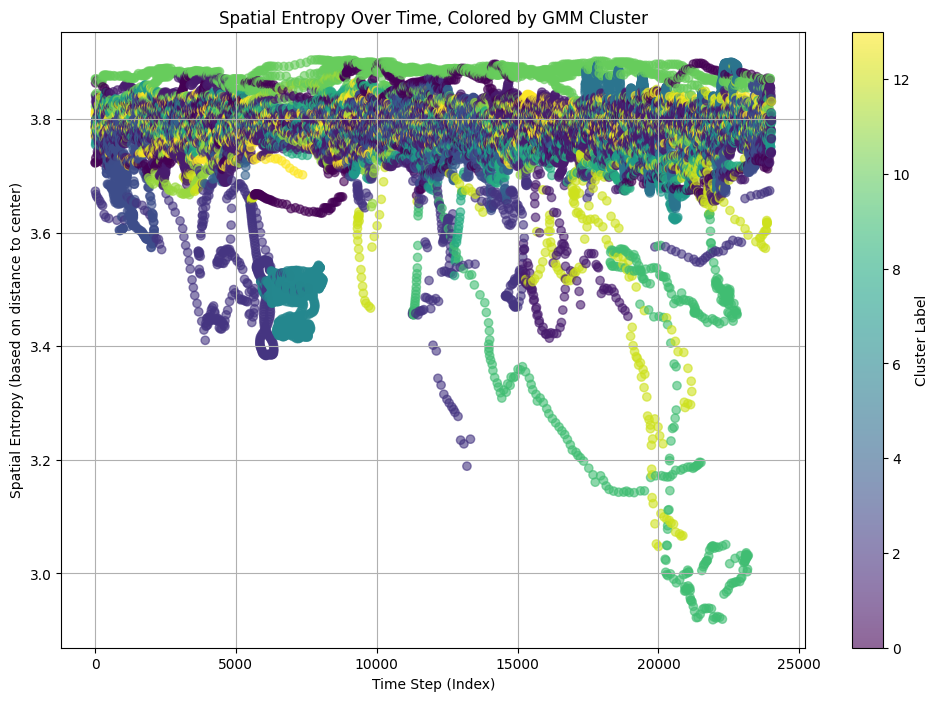

In [ ]:
plt.figure(figsize=(12, 8))
# Plot spatial entropy over time, color-coded by cluster label
scatter = plt.scatter(data.index, data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Time Step (Index)')
plt.ylabel('Spatial Entropy (based on distance to center)')
plt.title('Spatial Entropy Over Time, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()


Correlation Matrix (Spatial Entropy vs. Aggregate Features):
                        spatial_entropy  avg_velocity_magnitude  \
spatial_entropy                1.000000                0.402938   
avg_velocity_magnitude         0.402938                1.000000   
avg_distance_to_center         0.408259                0.072372   
avg_alignment                 -0.378982               -0.150883   

                        avg_distance_to_center  avg_alignment  
spatial_entropy                       0.408259      -0.378982  
avg_velocity_magnitude                0.072372      -0.150883  
avg_distance_to_center                1.000000       0.010766  
avg_alignment                         0.010766       1.000000  


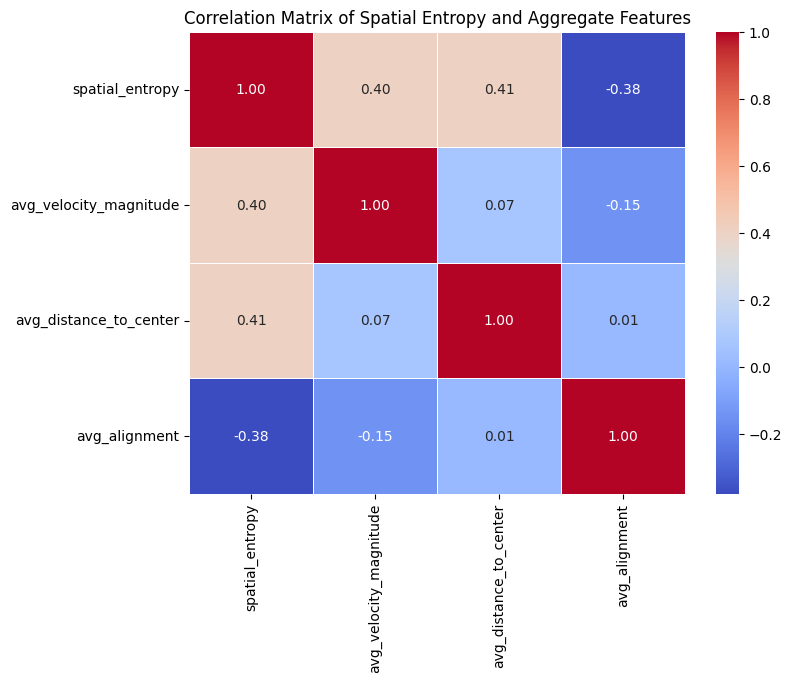

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data[['spatial_entropy', 'avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].corr()

print("\nCorrelation Matrix (Spatial Entropy vs. Aggregate Features):")
print(correlation_matrix)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Spatial Entropy and Aggregate Features')
plt.show()

In [ ]:
# Calculate the difference in spatial entropy between consecutive time steps
data['entropy_change'] = data['spatial_entropy'].diff()

# Identify transitions (where the cluster label changes from the previous time step)
data['cluster_transition'] = (data['cluster_label'].shift(1) != data['cluster_label'])

# Filter for rows where a transition occurred
transitions_df = data[data['cluster_transition']].copy()

# Analyze the average entropy change for transitions between specific cluster pairs
# This can be done by grouping by the previous and current cluster labels
if not transitions_df.empty:
    average_entropy_change_during_transitions = transitions_df.groupby(['cluster_label', data['cluster_label'].shift(1)])['entropy_change'].mean().unstack()
    print("\nAverage Entropy Change During Transitions (From row cluster to column cluster):")
    print(average_entropy_change_during_transitions)
else:
    print("\nNo cluster transitions found to analyze entropy changes.")


Average Entropy Change During Transitions (From row cluster to column cluster):
cluster_label      0.0       1.0       2.0       3.0       4.0       5.0   \
cluster_label                                                               
0                   NaN  0.025371  0.184535  0.036720  0.027412 -0.016240   
1             -0.010838       NaN  0.169886  0.014087  0.003454 -0.014377   
2             -0.184879 -0.168483       NaN -0.080891 -0.169590 -0.201224   
3             -0.026654 -0.019120  0.120654       NaN -0.011990 -0.099926   
4             -0.029552 -0.000066  0.161357  0.000768       NaN -0.004454   
5              0.007275  0.010833  0.195089  0.100857 -0.002743       NaN   
6             -0.251589 -0.294223  0.007083 -0.305148 -0.295001       NaN   
7             -0.029056 -0.014531  0.168881  0.008141 -0.000250 -0.065824   
8             -0.032762 -0.007465  0.178533  0.011738  0.009664 -0.050658   
9             -0.418281 -0.394949 -0.249214 -0.249896 -0.313040 -0.48115

Visualize Spatial Entropy vs. Other Aggregate Features (Scatter Plots):
Create scatter plots of spatial_entropy against avg_velocity_magnitude, avg_distance_to_center, and avg_alignment, color-coded by the GMM cluster labels. This will visually show how entropy relates to these other aggregate measures within and across different clusters.

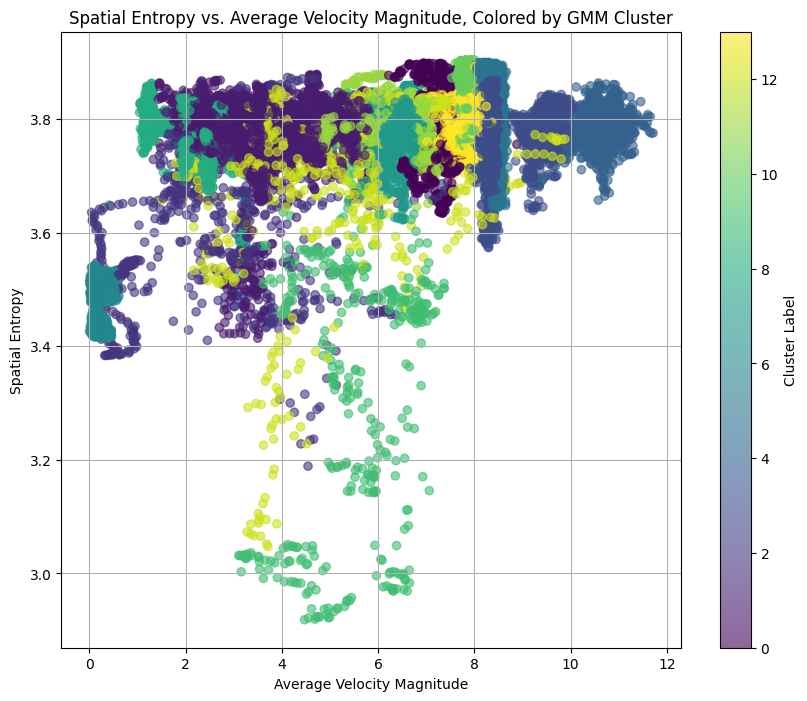

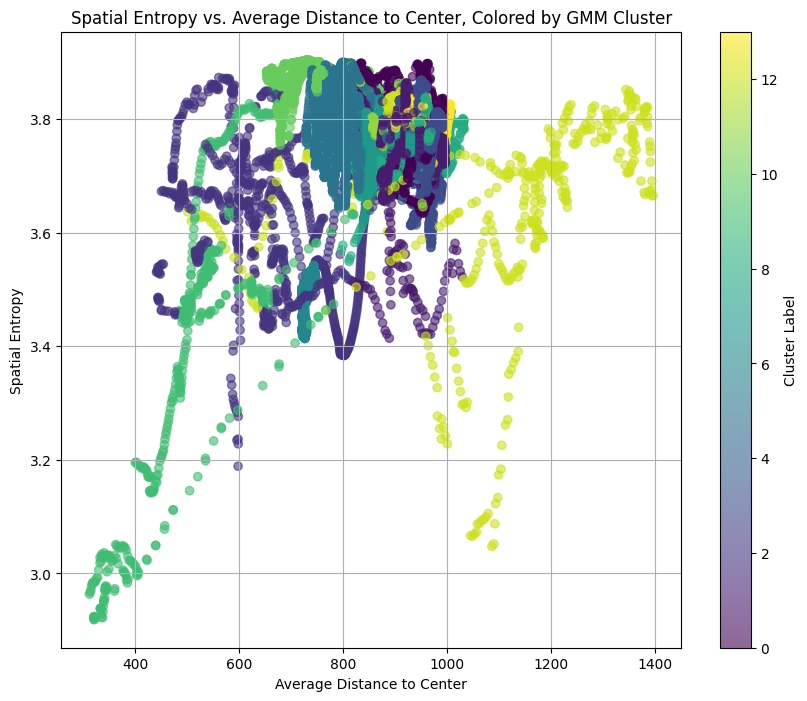

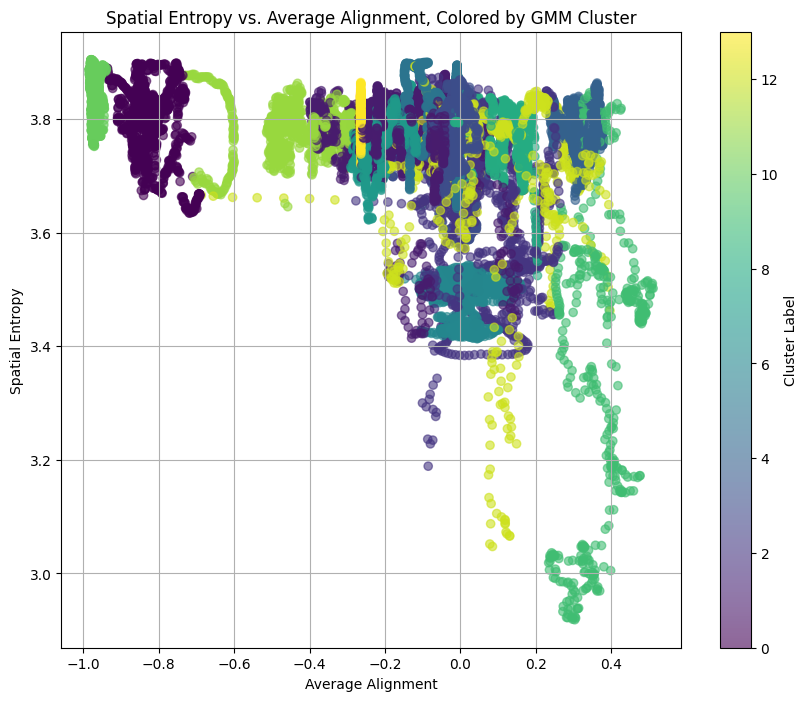

In [ ]:
# Scatter plot: Entropy vs. Average Velocity Magnitude
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_velocity_magnitude'], data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Velocity Magnitude')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy vs. Average Velocity Magnitude, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

# Scatter plot: Entropy vs. Average Distance to Center
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_distance_to_center'], data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Distance to Center')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy vs. Average Distance to Center, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

# Scatter plot: Entropy vs. Average Alignment
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_alignment'], data['spatial_entropy'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Alignment')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy vs. Average Alignment, Colored by GMM Cluster')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

Further Analyze Transition Pathways and Entropy Changes:
Beyond the average entropy change matrix, you could focus on specific transitions of interest. For example, examine transitions between clusters that represent "ordered" and "disordered" states.
You could also visualize the time series of entropy and highlight periods where transitions occur.

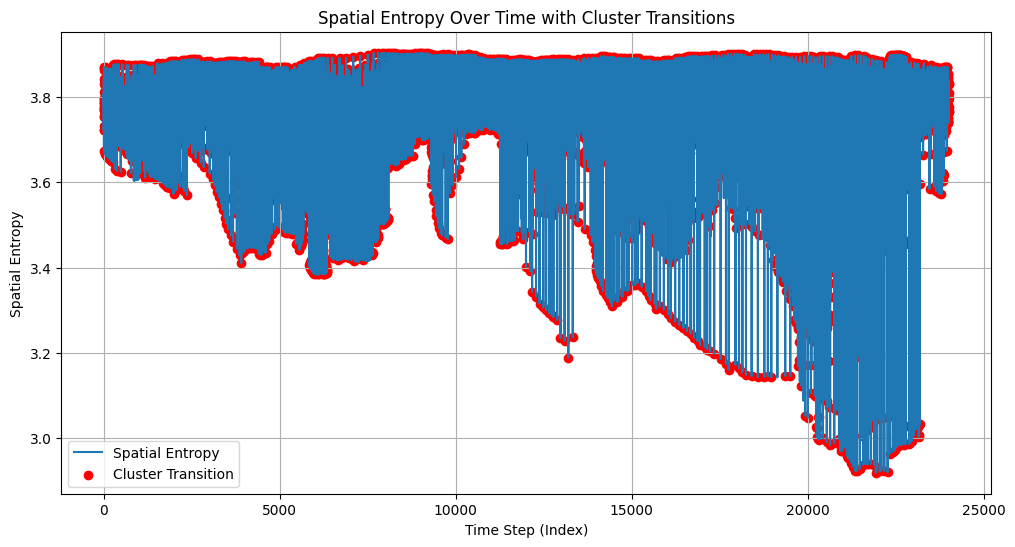

In [ ]:
# Visualize Entropy Over Time with Transition Points (Optional)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['spatial_entropy'], label='Spatial Entropy')
# Highlight transition points (where cluster_transition is True)
transition_indices = data[data['cluster_transition']].index
plt.scatter(transition_indices, data.loc[transition_indices, 'spatial_entropy'], color='red', marker='o', label='Cluster Transition')
plt.xlabel('Time Step (Index)')
plt.ylabel('Spatial Entropy')
plt.title('Spatial Entropy Over Time with Cluster Transitions')
plt.legend()
plt.grid(True)
plt.show()

## Introducing Next steps - Agent Base Modeling Forces

Analyzing Cluster Behavior with Respect to Alignment, Cohesion, and Separation:

We'll revisit the output of the mean feature values per cluster and explicitly interpret each cluster in terms of these three behaviors:

In [ ]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0

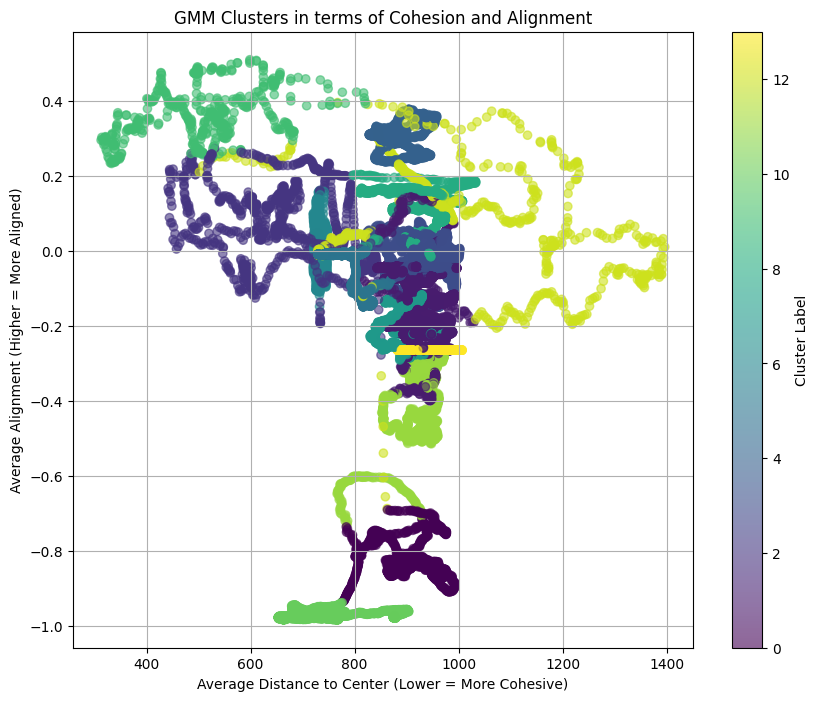

In [ ]:
# Scatter plot: Average Distance to Center vs. Average Alignment
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data['avg_distance_to_center'], data['avg_alignment'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
plt.xlabel('Average Distance to Center (Lower = More Cohesive)')
plt.ylabel('Average Alignment (Higher = More Aligned)')
plt.title('GMM Clusters in terms of Cohesion and Alignment')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

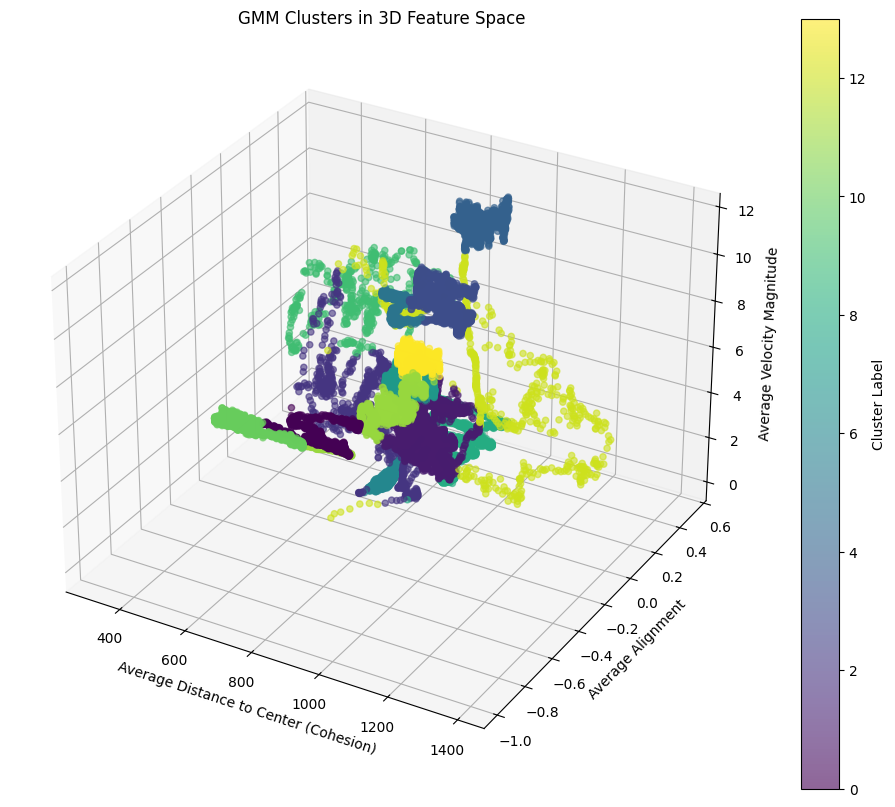

In [ ]:
# You can also create a 3D scatter plot if you want to include average velocity magnitude
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data['avg_distance_to_center'], data['avg_alignment'], data['avg_velocity_magnitude'], c=data['cluster_label'], cmap='viridis', alpha=0.6)

ax.set_xlabel('Average Distance to Center (Cohesion)')
ax.set_ylabel('Average Alignment')
ax.set_zlabel('Average Velocity Magnitude')
ax.set_title('GMM Clusters in 3D Feature Space')

fig.colorbar(scatter, label='Cluster Label')
plt.show()

let's create a summary table and map your GMM clusters to descriptive behavioral labels based on their mean aggregate features (average velocity magnitude, average distance to center, and average alignment).

In [ ]:
# Get the mean feature values per cluster
cluster_summary = data.groupby('cluster_label')[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].mean()

# Add a column for behavioral interpretation (we'll fill this in manually)
cluster_summary['Behavioral_Interpretation'] = ""

# Now, manually assign behavioral interpretations based on the mean values.
# Refer to the output of cluster_summary and your understanding of flocking.

# Example (you will need to adapt this based on your actual cluster means):
# For cluster 0:
# if cluster_summary.loc[0, 'avg_velocity_magnitude'] > some_threshold and \
#    cluster_summary.loc[0, 'avg_distance_to_center'] > some_threshold and \
#    cluster_summary.loc[0, 'avg_alignment'] < some_threshold:
#     cluster_summary.loc[0, 'Behavioral_Interpretation'] = 'Dispersed/High Velocity'

# For cluster 9:
# if cluster_summary.loc[9, 'avg_velocity_magnitude'] > some_moderate_threshold and \
#    cluster_summary.loc[9, 'avg_distance_to_center'] < some_low_threshold and \
#    cluster_summary.loc[9, 'avg_alignment'] > some_high_threshold:
#     cluster_summary.loc[9, 'Behavioral_Interpretation'] = 'Flocking/Cohesive and Aligned'

# For cluster 6:
# if cluster_summary.loc[6, 'avg_velocity_magnitude'] < some_low_threshold and \
#    cluster_summary.loc[6, 'avg_distance_to_center'] > some_moderate_threshold and \
#    cluster_summary.loc[6, 'avg_alignment'] < some_low_threshold:
#     cluster_summary.loc[6, 'Behavioral_Interpretation'] = 'Resting/Stagnant'


# You will need to add similar conditional logic or manually assign
# interpretations for all your clusters (0 to 13).

print("\nCluster Behavioral Summary:")
print(cluster_summary)
cluster_summary.to_csv("gmm_cluster_behavioral_summary.csv")


Cluster Behavioral Summary:
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0.365733   
10         

In [ ]:
# Add a column for behavioral interpretation
cluster_summary['Behavioral_Interpretation'] = ""

# Manually assign behavioral interpretations based on the agreed-upon labels for each cluster.
cluster_summary.loc[0, 'Behavioral_Interpretation'] = 'High Velocity Dispersed (Anti-aligned)'
cluster_summary.loc[1, 'Behavioral_Interpretation'] = 'Low Velocity Dispersed (Slightly Anti-aligned)'
cluster_summary.loc[2, 'Behavioral_Interpretation'] = 'Moderately Cohesive & Slow (Slightly Aligned)'
cluster_summary.loc[3, 'Behavioral_Interpretation'] = 'Very High Velocity Dispersed (Near Neutral Alignment)'
cluster_summary.loc[4, 'Behavioral_Interpretation'] = 'Extremely High Velocity Dispersed (Moderately Aligned)'
cluster_summary.loc[5, 'Behavioral_Interpretation'] = 'High Velocity Somewhat Cohesive (Near Neutral Alignment)'
cluster_summary.loc[6, 'Behavioral_Interpretation'] = 'Resting / Stagnant (Moderately Cohesive & Neutral Alignment)'
cluster_summary.loc[7, 'Behavioral_Interpretation'] = 'Moderate Velocity Dispersed (Slightly Anti-aligned)'
cluster_summary.loc[8, 'Behavioral_Interpretation'] = 'Very Low Velocity Dispersed (Slightly Aligned)'
cluster_summary.loc[9, 'Behavioral_Interpretation'] = 'Flocking / Cohesive & Aligned (Optimal Flocking)'
cluster_summary.loc[10, 'Behavioral_Interpretation'] = 'High Velocity Dispersed (Strongly Anti-aligned / Splitting)'
cluster_summary.loc[11, 'Behavioral_Interpretation'] = 'Moderate Velocity Dispersed (Anti-aligned)'
cluster_summary.loc[12, 'Behavioral_Interpretation'] = 'Highly Dispersed & Moderate Velocity (Near Neutral Alignment)'
cluster_summary.loc[13, 'Behavioral_Interpretation'] = 'High Velocity Dispersed (Slightly Anti-alignment)'

print("\nCluster Behavioral Summary with Interpretations:")
print(cluster_summary)

# You might want to save this summary to a CSV file for later use:
# cluster_summary.to_csv("gmm_cluster_behavioral_summary_with_interpretations.csv")


Cluster Behavioral Summary with Interpretations:
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0.

In [ ]:
print("\nMean feature values per cluster (original scale):")
print(data.groupby('cluster_label').mean())


Mean feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment  \
cluster_label                                                                  
0                            7.277666              900.597326      -0.824237   
1                            3.933459              922.447191      -0.139634   
2                            2.699689              660.199957       0.076446   
3                            8.899048              926.991113      -0.026827   
4                           10.581913              891.401929       0.313331   
5                            8.457994              790.054844      -0.032697   
6                            0.235559              731.654686       0.010271   
7                            6.372496              895.625886      -0.198947   
8                            2.058433              924.575542       0.086854   
9                            5.498109              508.709524       0

In [ ]:
print("\nStandard deviation of feature values per cluster (original scale):")
print(data.groupby('cluster_label')[['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].std())


Standard deviation of feature values per cluster (original scale):
               avg_velocity_magnitude  avg_distance_to_center  avg_alignment
cluster_label                                                               
0                            0.320445               53.812021       0.047889
1                            0.851499               30.275021       0.088752
2                            1.600744              106.096802       0.104287
3                            0.627384               43.152738       0.055791
4                            0.400965               34.737016       0.036754
5                            0.100342               25.992024       0.046908
6                            0.121253                6.738023       0.052837
7                            0.281824               34.805547       0.049254
8                            0.566088               49.269808       0.068338
9                            0.967739              110.238968       0.068898
10      

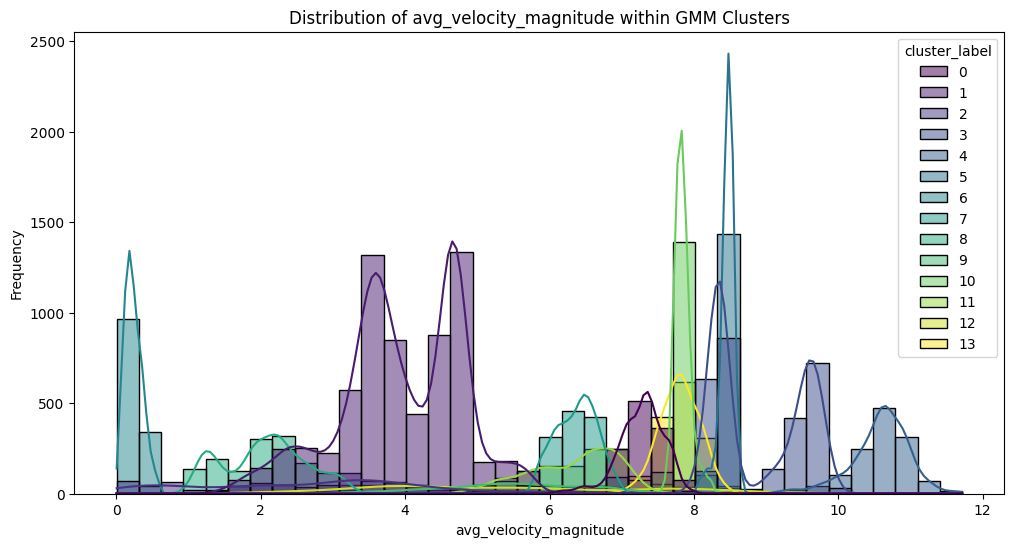

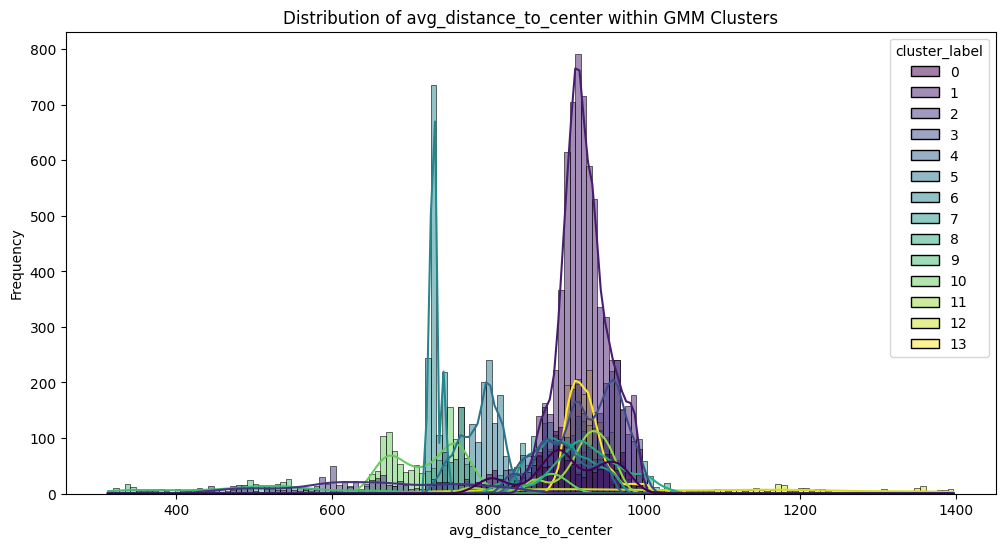

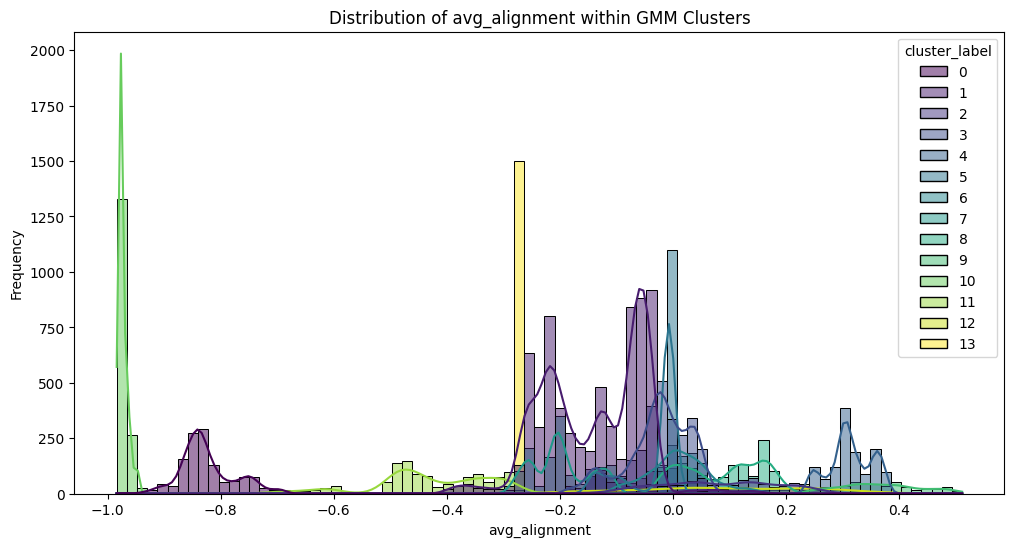

<ipython-input-41-56a19a806067>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='cluster_label', y=col, palette='viridis')


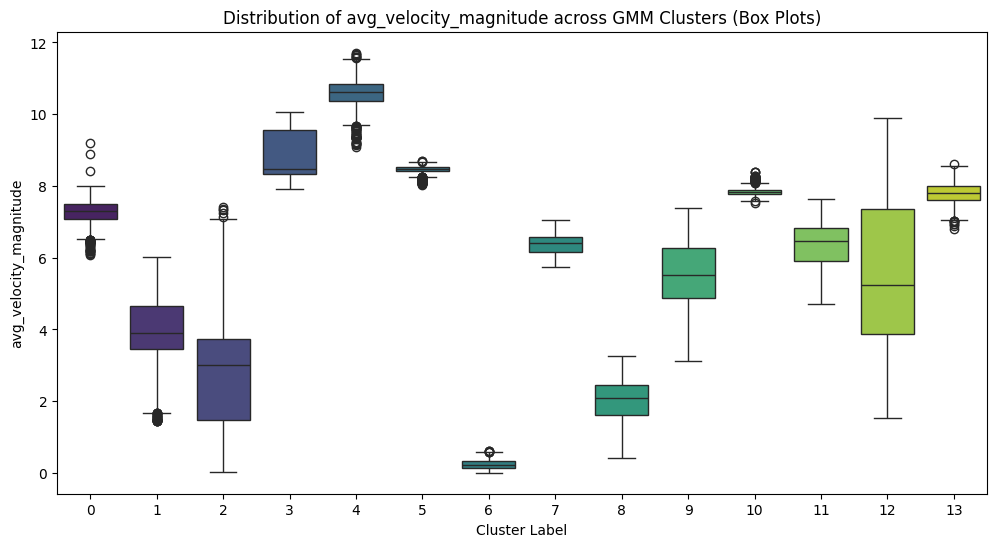

<ipython-input-41-56a19a806067>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='cluster_label', y=col, palette='viridis')


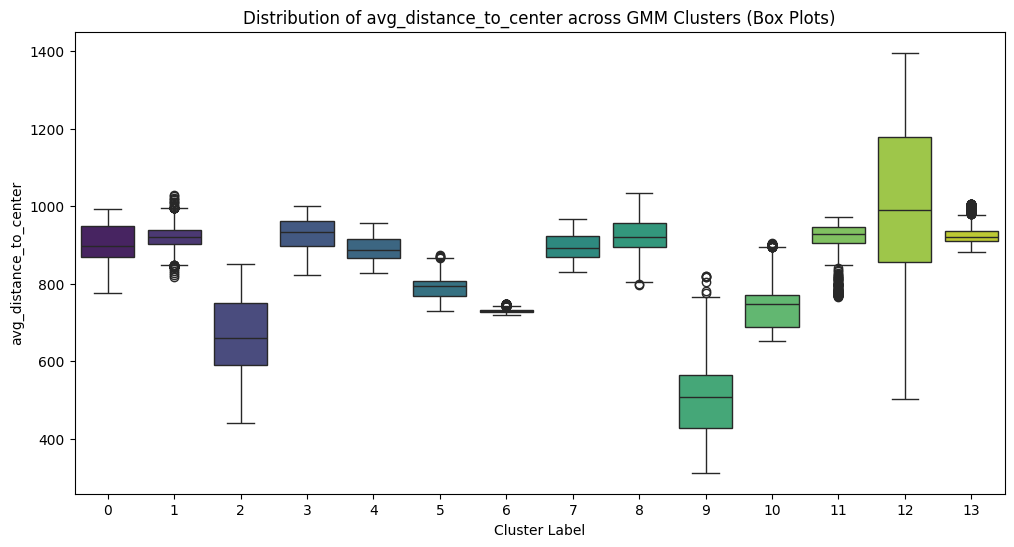

<ipython-input-41-56a19a806067>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='cluster_label', y=col, palette='viridis')


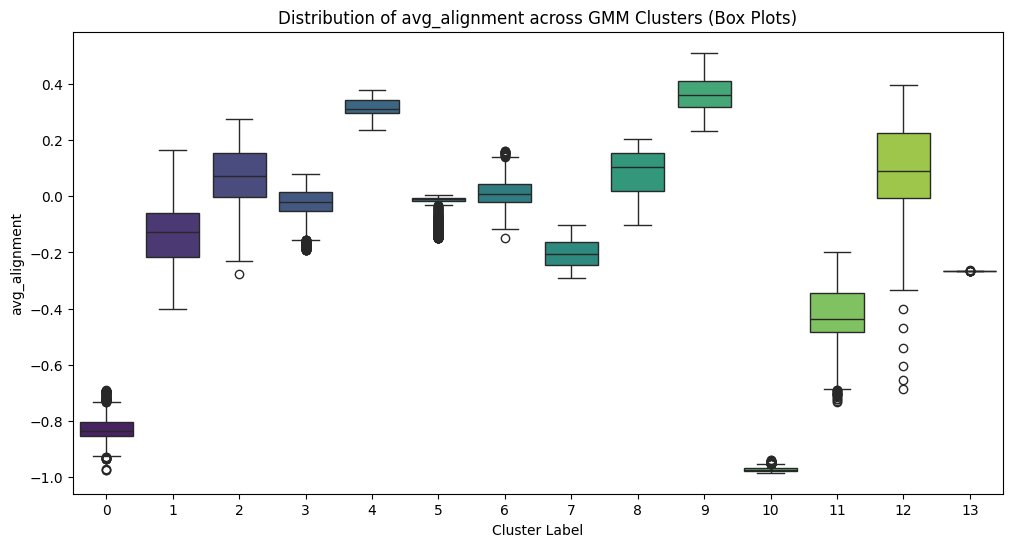

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

aggregate_cols = ['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']

for col in aggregate_cols:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=data, x=col, hue='cluster_label', kde=True, palette='viridis')
    plt.title(f'Distribution of {col} within GMM Clusters')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Alternatively, using box plots to show spread and outliers
for col in aggregate_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x='cluster_label', y=col, palette='viridis')
    plt.title(f'Distribution of {col} across GMM Clusters (Box Plots)')
    plt.xlabel('Cluster Label')
    plt.ylabel(col)
    plt.show()

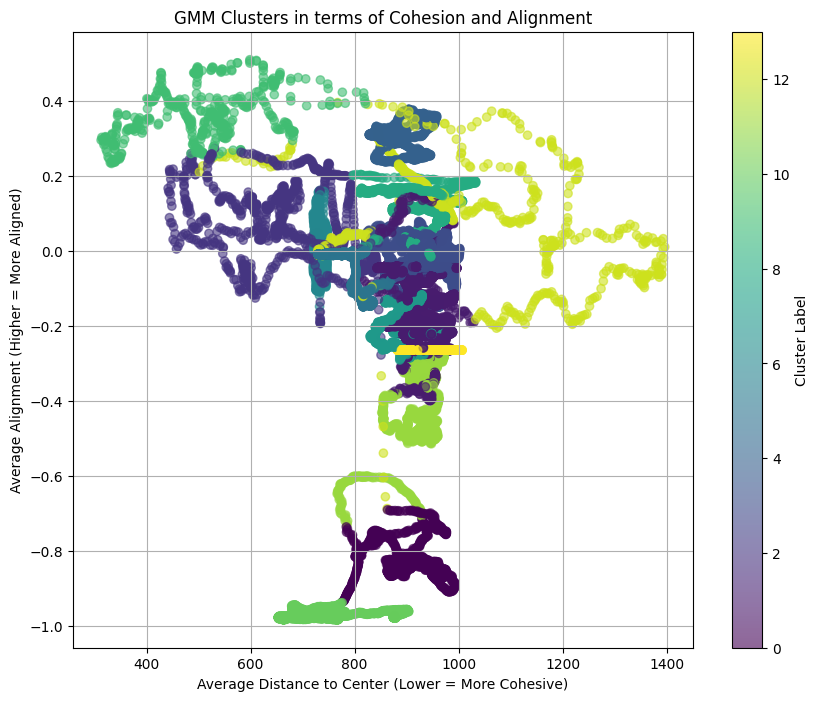

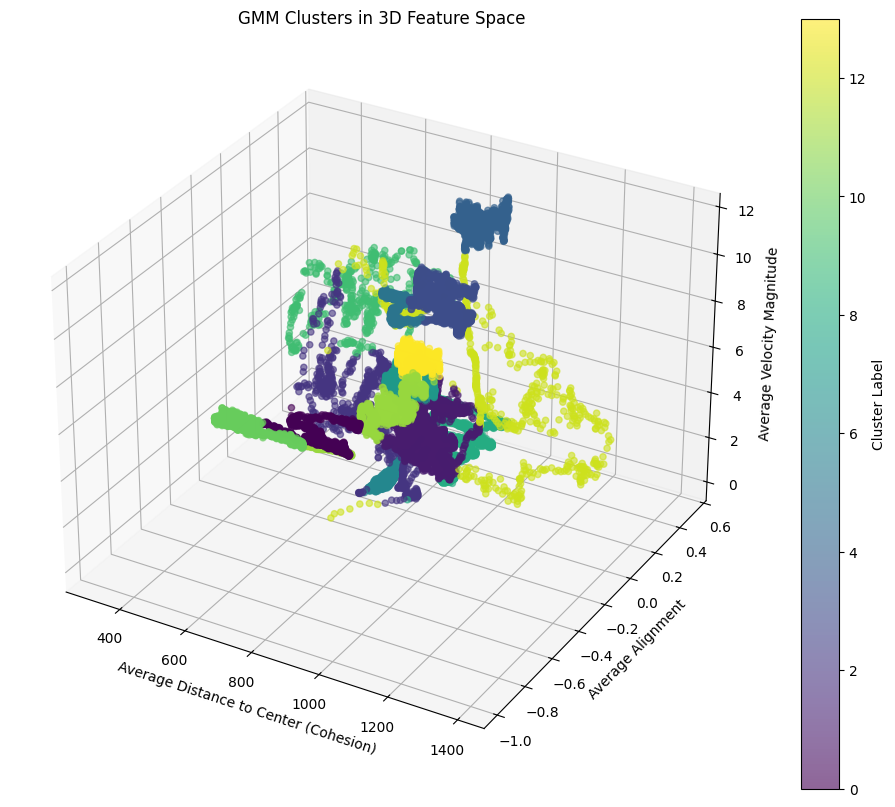

In [ ]:
    # Scatter plot: Average Distance to Center vs. Average Alignment
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data['avg_distance_to_center'], data['avg_alignment'], c=data['cluster_label'], cmap='viridis', alpha=0.6)
    plt.xlabel('Average Distance to Center (Lower = More Cohesive)')
    plt.ylabel('Average Alignment (Higher = More Aligned)')
    plt.title('GMM Clusters in terms of Cohesion and Alignment')
    plt.colorbar(scatter, label='Cluster Label')
    plt.grid(True)
    # Consider adding text annotations for some key clusters based on your interpretations


    # 3D scatter plot (Optional, if helpful)
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data['avg_distance_to_center'], data['avg_alignment'], data['avg_velocity_magnitude'], c=data['cluster_label'], cmap='viridis', alpha=0.6)

    ax.set_xlabel('Average Distance to Center (Cohesion)')
    ax.set_ylabel('Average Alignment')
    ax.set_zlabel('Average Velocity Magnitude')
    ax.set_title('GMM Clusters in 3D Feature Space')

    fig.colorbar(scatter, label='Cluster Label')
    # Consider adding text annotations in 3D (can be tricky)
    plt.show()

In [ ]:
# Print the normalized transition matrix again for easy reference
transition_probabilities = pd.crosstab(data['cluster_label'].shift(1), data['cluster_label']).div(pd.crosstab(data['cluster_label'].shift(1), data['cluster_label']).sum(axis=1), axis=0)
print("\nNormalized Transition Matrix (Probabilities):")
print(transition_probabilities)


Normalized Transition Matrix (Probabilities):
cluster_label        0         1         2         3         4         5   \
cluster_label                                                               
0.0            0.056872  0.322275  0.047393  0.109005  0.067930  0.044234   
1.0            0.057046  0.291538  0.034463  0.076697  0.056900  0.095615   
2.0            0.055294  0.270588  0.101176  0.084706  0.078824  0.011765   
3.0            0.047887  0.192606  0.021479  0.392606  0.038380  0.015493   
4.0            0.063035  0.306615  0.052140  0.091051  0.079377  0.034241   
5.0            0.033544  0.412658  0.006962  0.021519  0.036709  0.081646   
6.0            0.020706  0.104294  0.028374  0.002301  0.024540  0.000000   
7.0            0.058868  0.280755  0.031698  0.144906  0.044528  0.075472   
8.0            0.052557  0.331676  0.042614  0.104403  0.056818  0.067472   
9.0            0.057778  0.251111  0.026667  0.113333  0.035556  0.226667   
10.0           0.058096  0.31

In [ ]:
print("\nMean Spatial Entropy per Cluster:")
print(data.groupby('cluster_label')['spatial_entropy'].mean())

print("\nCorrelation Matrix (Spatial Entropy vs. Aggregate Features):")
print(data[['spatial_entropy', 'avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment']].corr())


Mean Spatial Entropy per Cluster:
cluster_label
0     3.799737
1     3.782166
2     3.603687
3     3.767049
4     3.782778
5     3.798217
6     3.492488
7     3.774251
8     3.777056
9     3.389129
10    3.860865
11    3.782821
12    3.687565
13    3.792311
Name: spatial_entropy, dtype: float64

Correlation Matrix (Spatial Entropy vs. Aggregate Features):
                        spatial_entropy  avg_velocity_magnitude  \
spatial_entropy                1.000000                0.402938   
avg_velocity_magnitude         0.402938                1.000000   
avg_distance_to_center         0.408259                0.072372   
avg_alignment                 -0.378982               -0.150883   

                        avg_distance_to_center  avg_alignment  
spatial_entropy                       0.408259      -0.378982  
avg_velocity_magnitude                0.072372      -0.150883  
avg_distance_to_center                1.000000       0.010766  
avg_alignment                         0.010766   

1. Negative Log-Likelihood of the Evolutions (using GMM):

The negative log-likelihood (NLL) is a measure of how well your GMM fits the data. Lower NLL indicates a better fit. We can calculate the NLL for your fitted best_gmm model on the scaled data.

In [ ]:
# Calculate the negative log-likelihood of the scaled data under the best GMM
# The score method returns the log-likelihood, so we take the negative
nll = -best_gmm.score(X_scaled)

print(f"\nNegative Log-Likelihood of the data under the best GMM: {nll}")


Negative Log-Likelihood of the data under the best GMM: 1.392629478089172


KL Divergence Analysis

In [ ]:
from scipy.stats import entropy, gaussian_kde
import numpy as np

# Choose two cluster labels to compare
cluster1_label = 9 # Example: Your 'Flocking' cluster
cluster2_label = 0 # Example: Your 'Dispersed' cluster

# Get the data for the chosen feature within each cluster
feature_to_compare = 'avg_velocity_magnitude'
data_cluster1 = data[data['cluster_label'] == cluster1_label][feature_to_compare].dropna()
data_cluster2 = data[data['cluster_label'] == cluster2_label][feature_to_compare].dropna()

if len(data_cluster1) > 1 and len(data_cluster2) > 1:
    # Estimate KDE for each distribution
    kde1 = gaussian_kde(data_cluster1)
    kde2 = gaussian_kde(data_cluster2)

    # Define a common range of points to evaluate the KDEs
    min_val = min(data_cluster1.min(), data_cluster2.min())
    max_val = max(data_cluster1.max(), data_cluster2.max())
    eval_points = np.linspace(min_val, max_val, 100) # Adjust number of points as needed

    # Evaluate the KDEs at the common points to get probability estimates
    p = kde1.evaluate(eval_points)
    q = kde2.evaluate(eval_points)

    # Add a small epsilon to avoid log(0) and division by zero
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon

    # Normalize to get probability distributions (optional, but good practice)
    p /= p.sum()
    q /= q.sum()

    # Calculate KL Divergence (KL(P || Q))
    # Note: entropy function in scipy can calculate KL divergence
    kl_divergence = entropy(p, qk=q)

    print(f"\nKL Divergence (Distribution of {feature_to_compare} in Cluster {cluster1_label} || Distribution in Cluster {cluster2_label}): {kl_divergence}")

else:
    print(f"\nCould not calculate KL Divergence: Insufficient data in one or both clusters for feature '{feature_to_compare}'.")


KL Divergence (Distribution of avg_velocity_magnitude in Cluster 9 || Distribution in Cluster 0): 13.2246326710922


3. Comparing Up to 4 Clustering Methods:

Beyond GMM, we compared its performance to other clustering algorithms on your aggregate features. Common methods include:

K-Means: Partitional clustering that aims to minimize the within-cluster sum of squares. Requires specifying the number of clusters.

Spectral Clustering: Uses the eigenvalues of a similarity matrix to perform dimensionality reduction before clustering. Can capture non-convex shapes. Requires specifying the number of clusters.

Agglomerative Clustering: Hierarchical clustering that merges clusters iteratively. Requires specifying the number of clusters or a distance threshold.

DBSCAN: Density-based clustering that groups together closely packed points. Does not require specifying the number of clusters but requires parameters for neighborhood size (eps) and minimum number of samples in a neighborhood (min_samples).

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
import numpy as np

# Assume X_scaled is your scaled aggregate features

# GMM (using your best_gmm from previous analysis)
gmm_labels = best_gmm.predict(X_scaled)
gmm_n_clusters = best_gmm.n_components # Number of clusters found by GMM


# K-Means
# You might choose the number of clusters based on the optimal number from GMM
kmeans = KMeans(n_clusters=gmm_n_clusters, random_state=42, n_init=10) # n_init for robustness
kmeans_labels = kmeans.fit_predict(X_scaled)


# Spectral Clustering
# You might need to experiment with the affinity parameter ('nearest_neighbors', 'rbf')
# and the number of neighbors if using 'nearest_neighbors'
spectral = SpectralClustering(n_clusters=gmm_n_clusters, assign_labels='discretize', random_state=42, affinity='nearest_neighbors', n_neighbors=10) # Example parameters
spectral_labels = spectral.fit_predict(X_scaled)


# Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=gmm_n_clusters)
agg_labels = agg_cluster.fit_predict(X_scaled)


# DBSCAN (Requires parameter tuning - eps and min_samples)
# DBSCAN does not require specifying the number of clusters beforehand,
# and the number of clusters found might be different from the GMM number.
# You'll need to choose eps and min_samples based on your data density.
# Use techniques like a k-distance graph to help choose eps.
#dbscan = DBSCAN(eps=0.5, min_samples=5) # Example parameters - you NEED to tune these
#dbscan_labels = dbscan.fit_predict(X_scaled)
#dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) # -1 is the label for noise points


# --- Evaluate Clustering Results ---
# Use metrics to compare the quality of the clusterings.
# Note: Silhouette Score, Davies-Bouldin, and Calinski-Harabasz are for evaluating
# the quality of the clustering itself (how well-separated and compact the clusters are).
# Adjusted Rand Score (ARI) is for comparing two different clusterings (if you had ground truth labels,
# or comparing one clustering to another).

print("\n--- Clustering Comparison Metrics ---")

# GMM Metrics
print("\nGMM Metrics:")
# Silhouette Score (higher is better, range [-1, 1])
if gmm_n_clusters > 1:
    print(f"  Silhouette Score: {silhouette_score(X_scaled, gmm_labels)}")
# Davies-Bouldin Index (lower is better, 0 is best)
if gmm_n_clusters > 1:
     print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, gmm_labels)}")
# Calinski-Harabasz Index (higher is better)
if gmm_n_clusters > 1:
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, gmm_labels)}")


# K-Means Metrics
print("\nK-Means Metrics:")
if gmm_n_clusters > 1:
    print(f"  Silhouette Score: {silhouette_score(X_scaled, kmeans_labels)}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_labels)}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, kmeans_labels)}")
    # Adjusted Rand Score (comparing K-Means to GMM)
    print(f"  Adjusted Rand Score (vs GMM): {adjusted_rand_score(gmm_labels, kmeans_labels)}")


# Spectral Clustering Metrics
print("\nSpectral Clustering Metrics:")
if gmm_n_clusters > 1:
    print(f"  Silhouette Score: {silhouette_score(X_scaled, spectral_labels)}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, spectral_labels)}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, spectral_labels)}")
     # Adjusted Rand Score (comparing Spectral to GMM)
    print(f"  Adjusted Rand Score (vs GMM): {adjusted_rand_score(gmm_labels, spectral_labels)}")


# Agglomerative Clustering Metrics
print("\nAgglomerative Clustering Metrics:")
if gmm_n_clusters > 1:
    print(f"  Silhouette Score: {silhouette_score(X_scaled, agg_labels)}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, agg_labels)}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, agg_labels)}")
     # Adjusted Rand Score (comparing Agglomerative to GMM)
    print(f"  Adjusted Rand Score (vs GMM): {adjusted_rand_score(gmm_labels, agg_labels)}")


# DBSCAN Metrics (if it found more than 1 cluster)
#print("\nDBSCAN Metrics:")
#if dbscan_n_clusters > 1:
    # Filter out noise points (-1 label) for evaluation metrics if they don't handle it
    # Most metrics can handle it if you provide the full labels and data, but check documentation
    # For simplicity here, assuming metrics can handle the -1 label
    #print(f"  Number of clusters found (excluding noise): {dbscan_n_clusters}")
    # Silhouette Score (requires at least 2 clusters and more than 1 sample per cluster)
    #try:
        #if dbscan_n_clusters > 1 and len(np.unique(dbscan_labels)) > 1:
             #print(f"  Silhouette Score: {silhouette_score(X_scaled, dbscan_labels)}")
             #print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_scaled, dbscan_labels)}")
             #print(f"  Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, dbscan_labels)}")
             # Adjusted Rand Score (comparing DBSCAN to GMM)
             #print(f"  Adjusted Rand Score (vs GMM): {adjusted_rand_score(gmm_labels, dbscan_labels)}")
        #else:
            #print("  Cannot calculate metrics: DBSCAN found 1 or 0 clusters (excluding noise) or insufficient samples.")
    #except Exception as e:
        #print(f"  Error calculating DBSCAN metrics: {e}")


# --- Further Analysis (Optional) ---
# You can also visually compare the clusterings by plotting the results of each algorithm
# on the same scatter plots you used for GMM, using the different sets of labels.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



--- Clustering Comparison Metrics ---

GMM Metrics:
  Silhouette Score: 0.3838236521128623
  Davies-Bouldin Index: 1.2404070333460304
  Calinski-Harabasz Index: 12681.287623213237

K-Means Metrics:
  Silhouette Score: 0.441434006625682
  Davies-Bouldin Index: 0.8915067111020607
  Calinski-Harabasz Index: 23363.66076000041
  Adjusted Rand Score (vs GMM): 0.604016377547069

Spectral Clustering Metrics:
  Silhouette Score: 0.32048735683338236
  Davies-Bouldin Index: 1.3207513137254077
  Calinski-Harabasz Index: 9495.857724606682
  Adjusted Rand Score (vs GMM): 0.6302035097354236

Agglomerative Clustering Metrics:
  Silhouette Score: 0.398727859999243
  Davies-Bouldin Index: 0.9356167003071901
  Calinski-Harabasz Index: 21232.95271900658
  Adjusted Rand Score (vs GMM): 0.5644609373039127


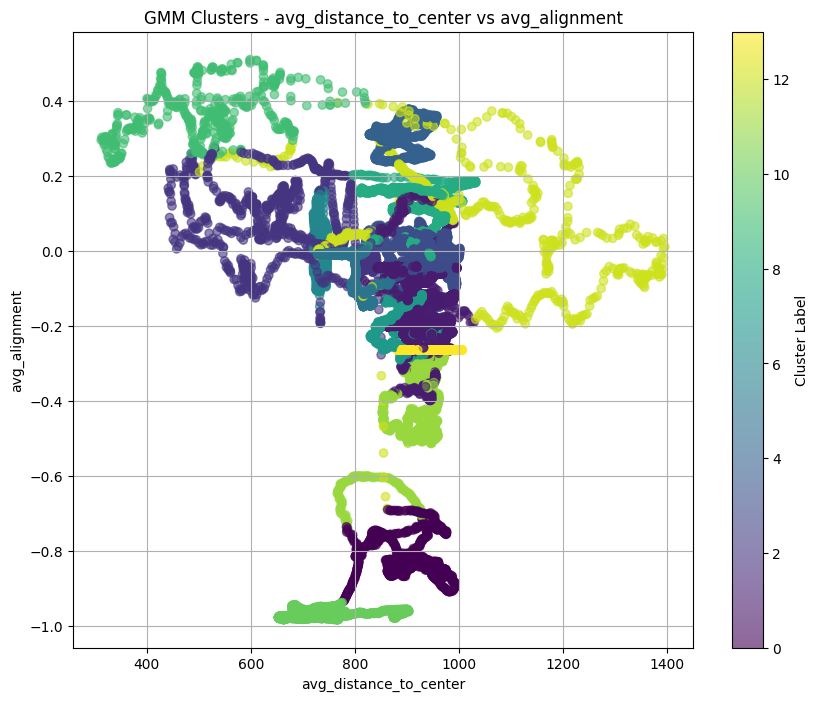

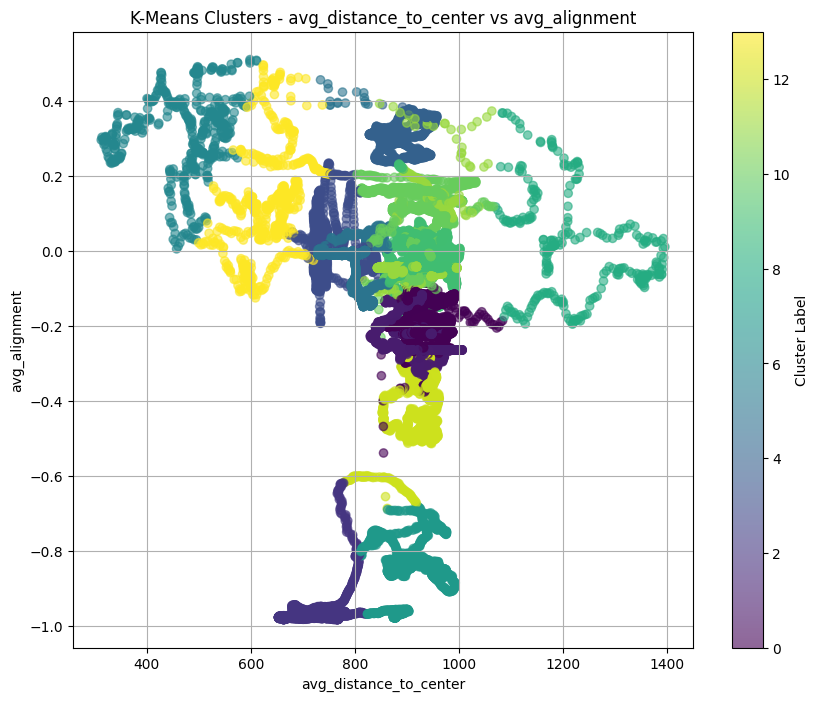

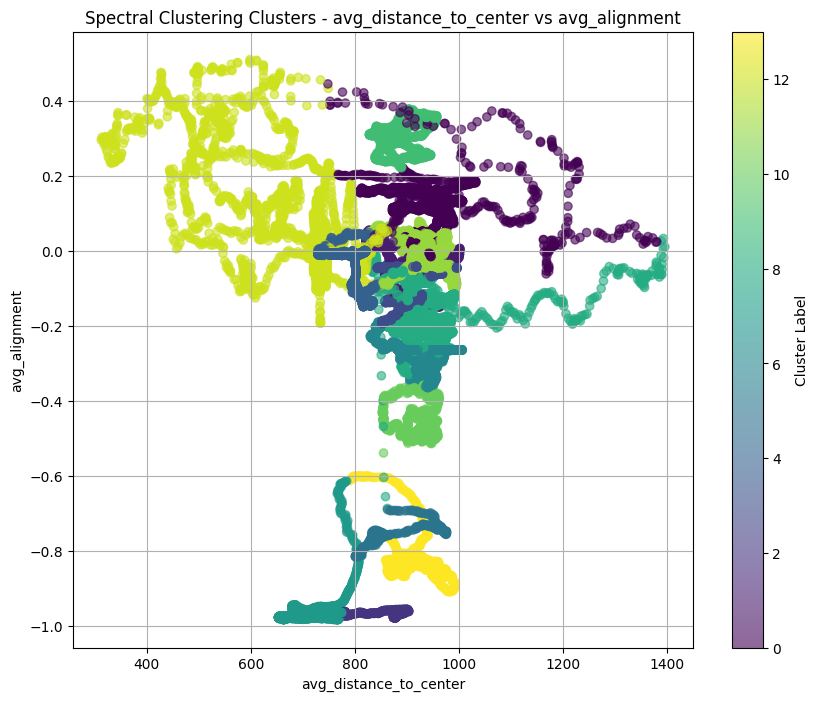

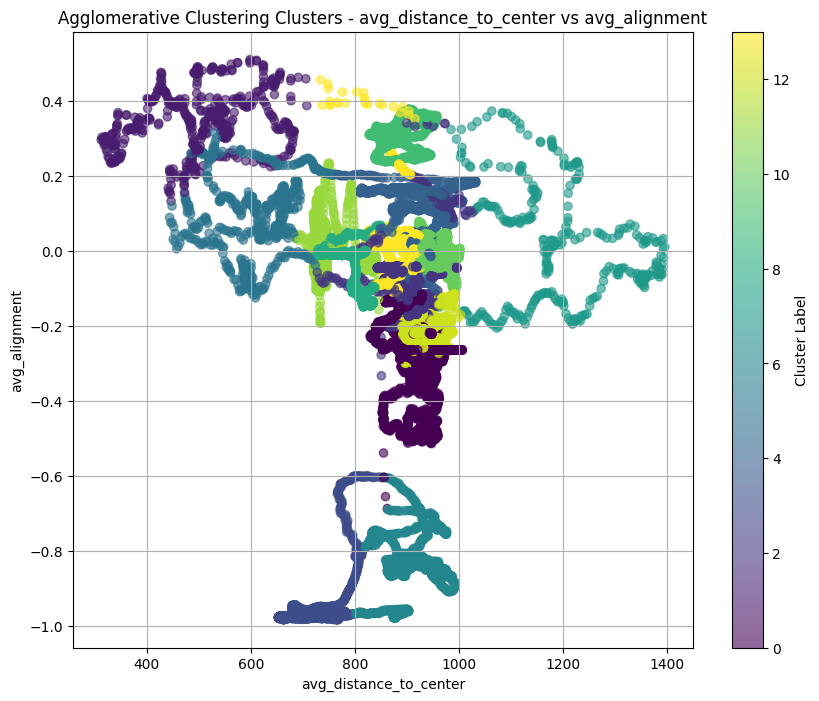

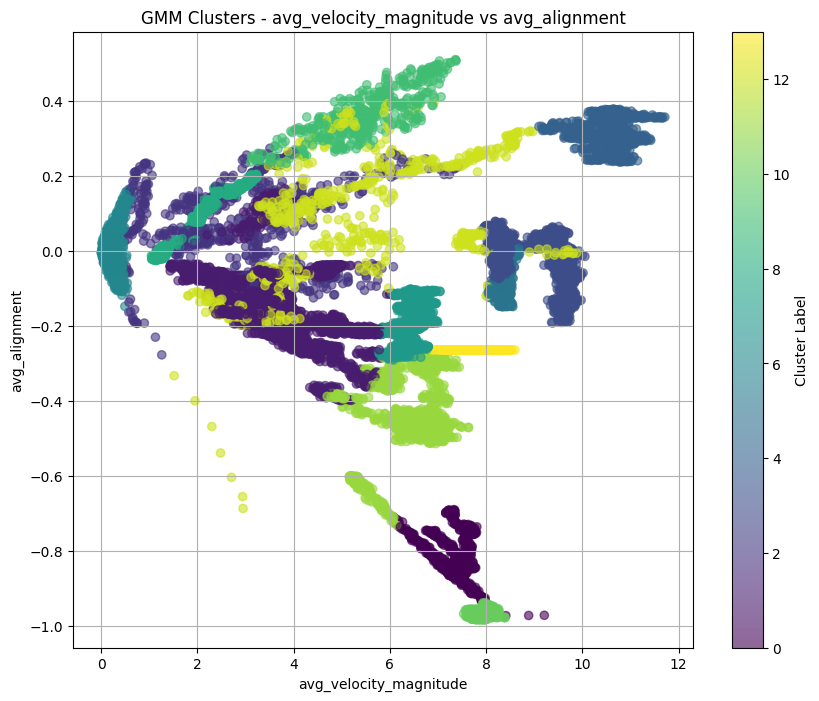

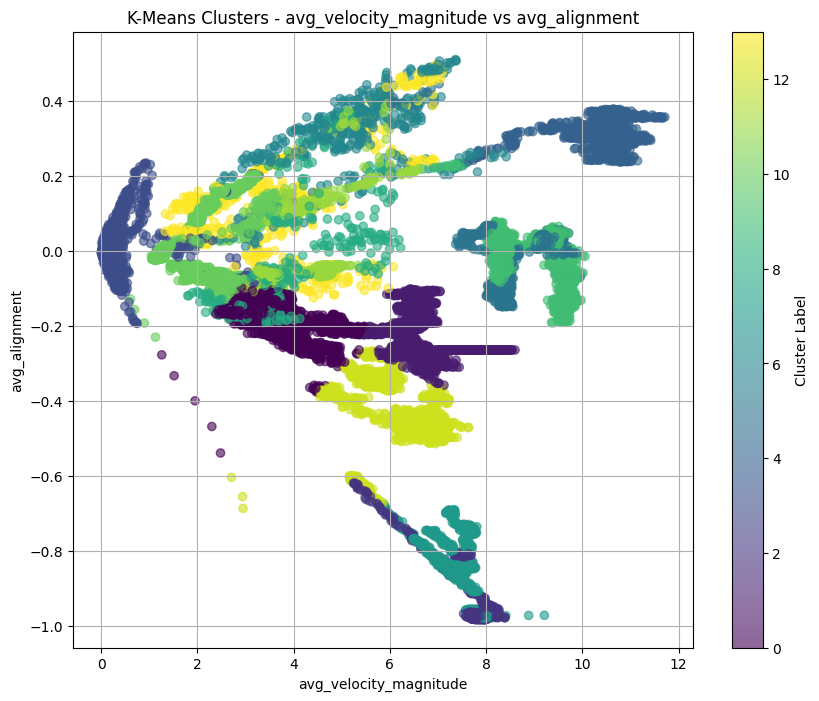

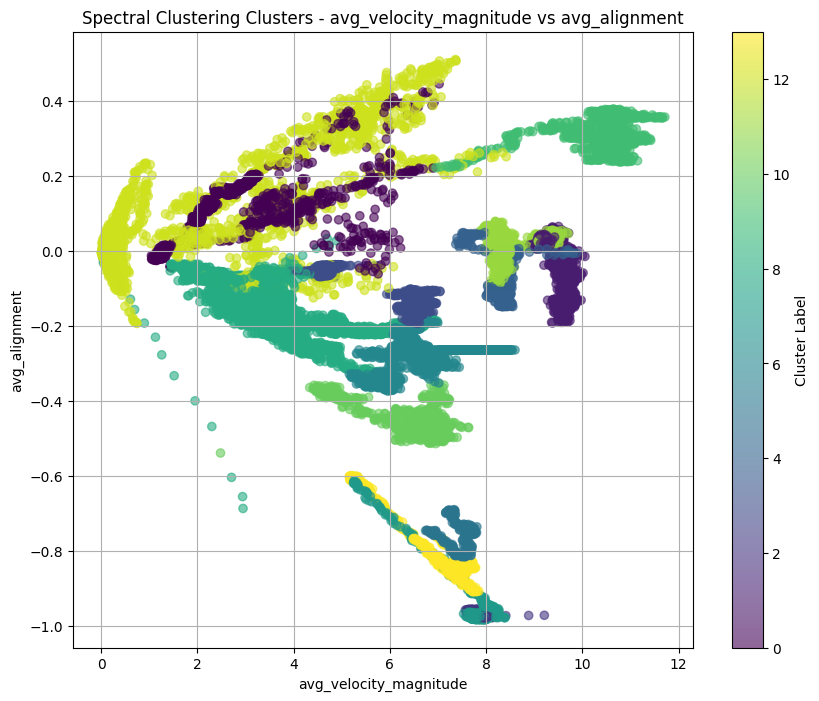

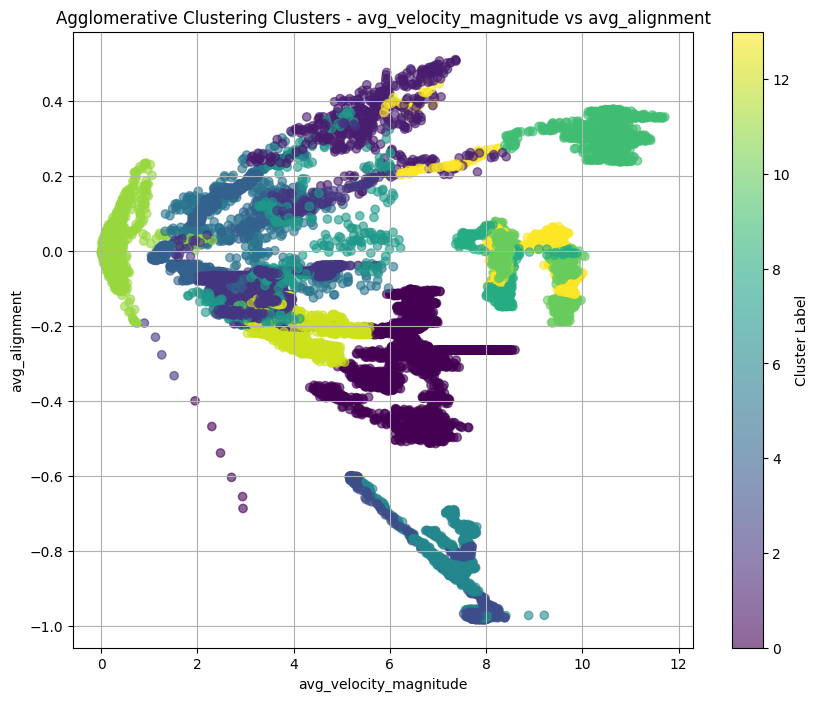

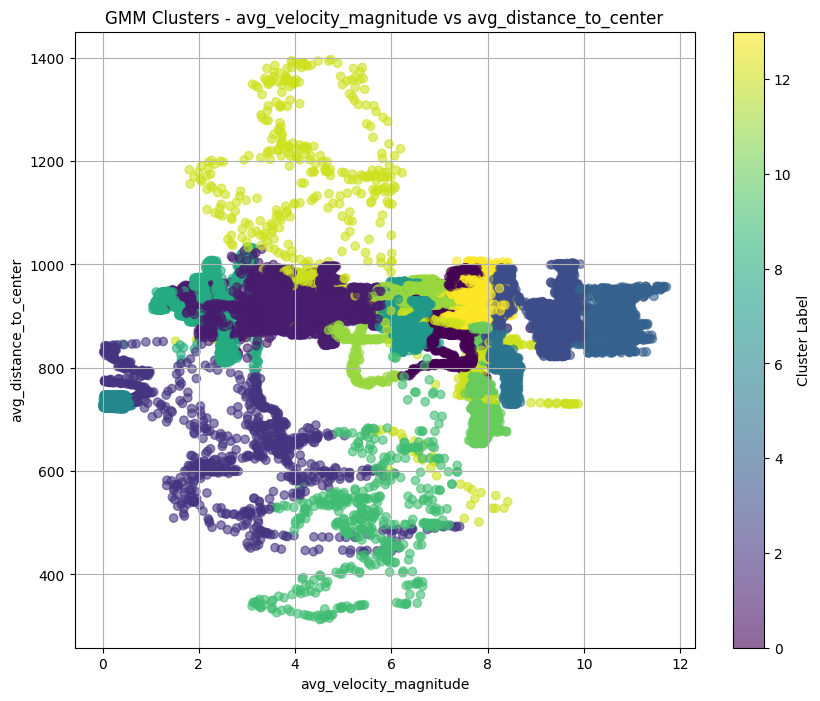

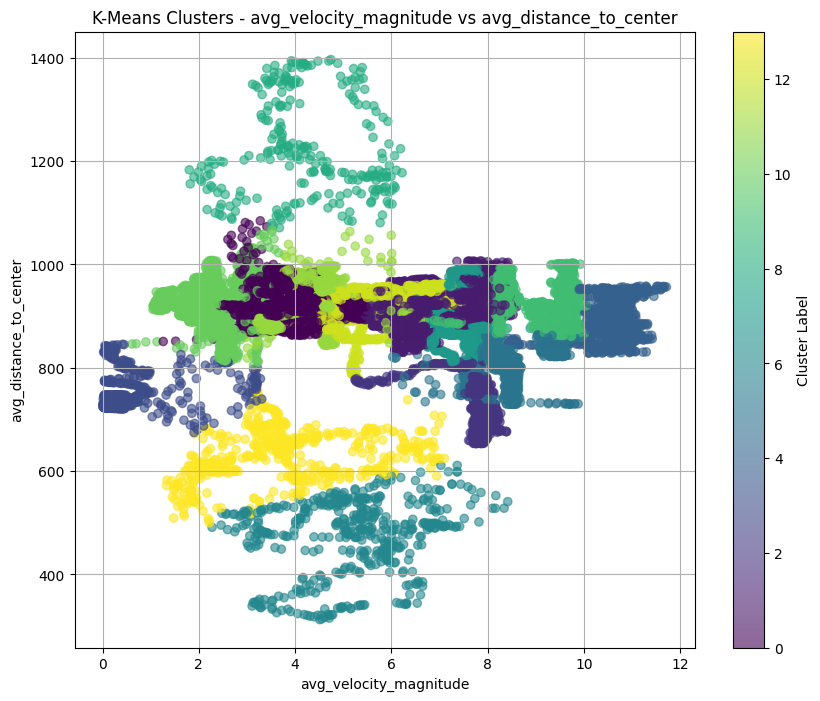

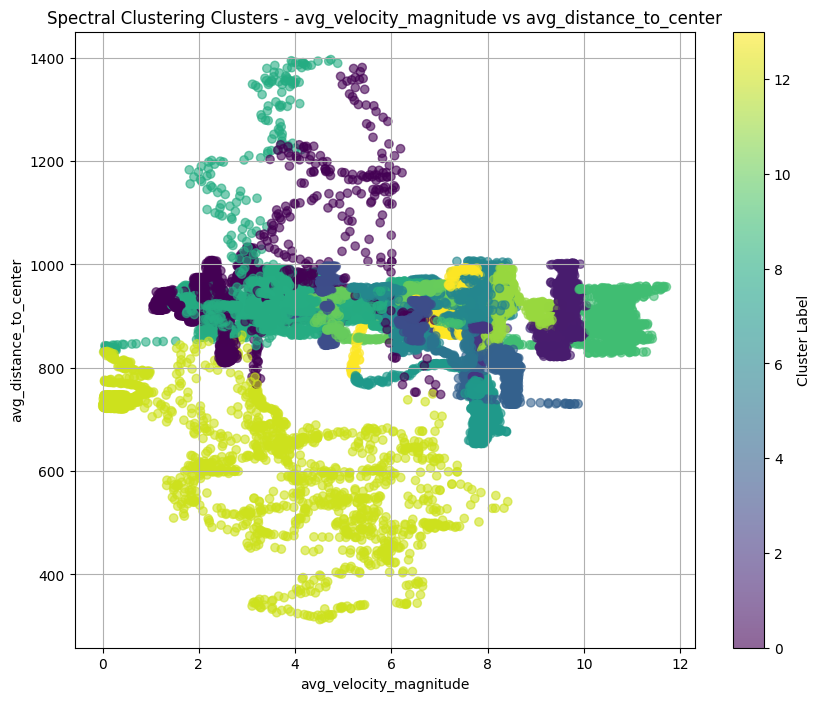

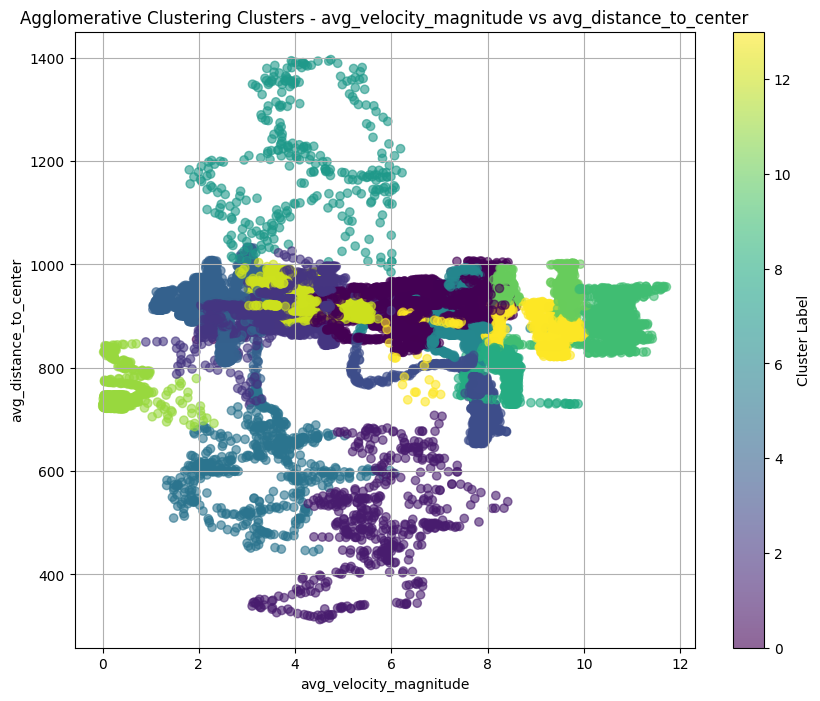

In [ ]:
# Assuming you have the following variables from the clustering comparison code:
# X_scaled: Your scaled data
# gmm_labels: Cluster labels from GMM
# kmeans_labels: Cluster labels from K-Means
# spectral_labels: Cluster labels from Spectral Clustering
# agg_labels: Cluster labels from Agglomerative Clustering
# dbscan_labels: Cluster labels from DBSCAN (includes -1 for noise)
# data: Your DataFrame with original features and cluster labels (ensure it's aligned with X_scaled)


# Define the pairs of features you want to plot
feature_pairs_to_plot = [
    ('avg_distance_to_center', 'avg_alignment'),
    ('avg_velocity_magnitude', 'avg_alignment'),
    ('avg_velocity_magnitude', 'avg_distance_to_center')
]

# Define the clustering labels and their names
clustering_results = {
    'GMM': gmm_labels,
    'K-Means': kmeans_labels,
    'Spectral Clustering': spectral_labels,
    'Agglomerative Clustering': agg_labels,
    #'DBSCAN': dbscan_labels
}

# Create scatter plots for each feature pair and each clustering result
for feature1_name, feature2_name in feature_pairs_to_plot:
    # Get the original (unscaled) data for the selected features for plotting
    feature1_data = data[feature1_name]
    feature2_data = data[feature2_name]

    for clustering_name, labels in clustering_results.items():
        plt.figure(figsize=(10, 8))

        # Handle DBSCAN noise points (-1 label) by plotting them separately
        if clustering_name == 'DBSCAN':
            # Separate noise points and clustered points
            noise_mask = (labels == -1)
            clustered_mask = ~noise_mask

            # Plot clustered points
            scatter = plt.scatter(feature1_data[clustered_mask], feature2_data[clustered_mask], c=labels[clustered_mask], cmap='viridis', alpha=0.6)
            # Plot noise points
            plt.scatter(feature1_data[noise_mask], feature2_data[noise_mask], c='gray', marker='x', alpha=0.6, label='Noise')
            plt.legend() # Add legend to show Noise label

        else:
            scatter = plt.scatter(feature1_data, feature2_data, c=labels, cmap='viridis', alpha=0.6)


        plt.xlabel(feature1_name)
        plt.ylabel(feature2_name)
        plt.title(f'{clustering_name} Clusters - {feature1_name} vs {feature2_name}')
        plt.colorbar(scatter, label='Cluster Label')
        plt.grid(True)
        plt.show()

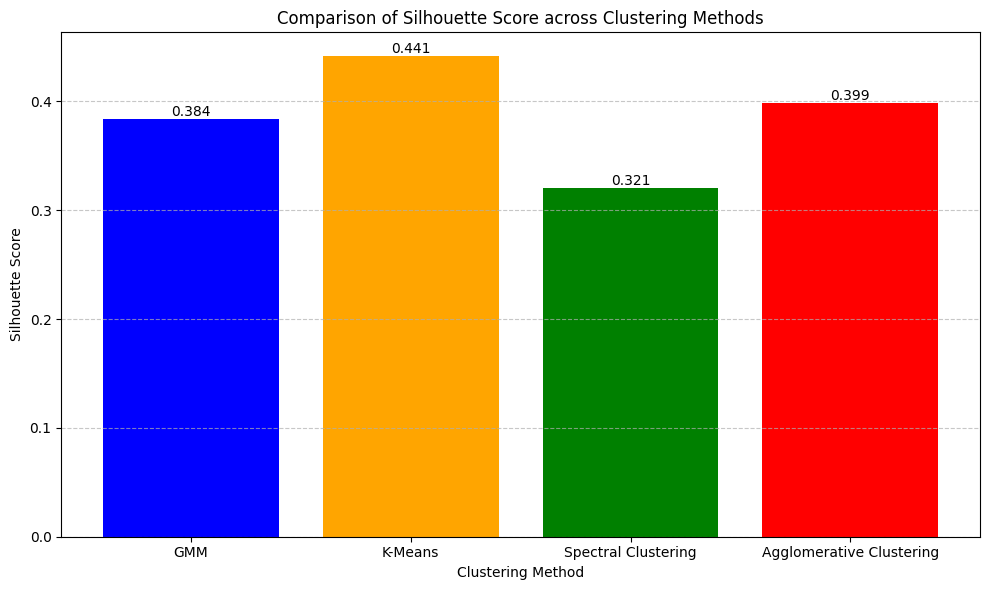

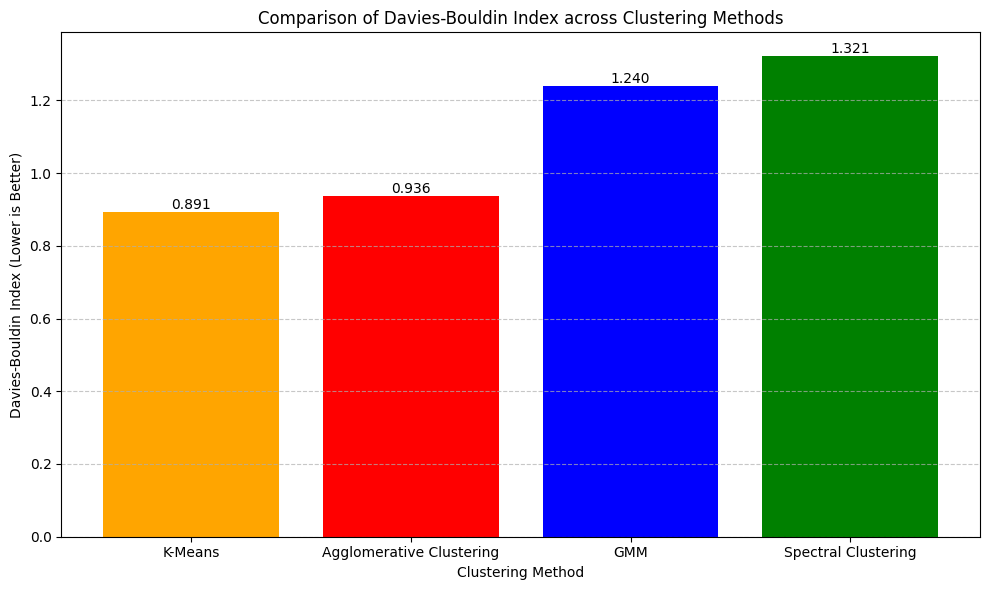

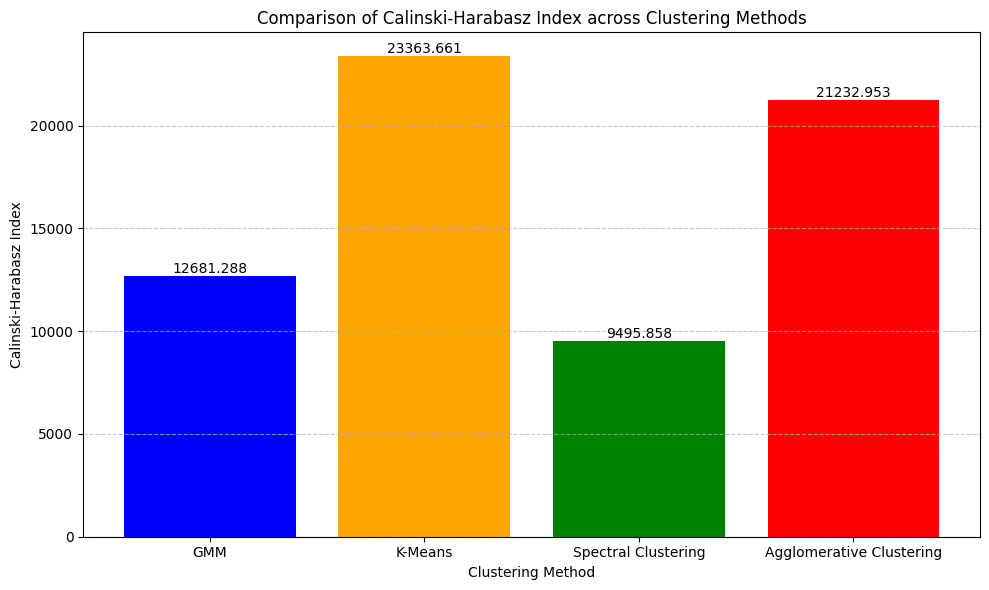

In [ ]:
# Assuming you have the following metric values from your previous output:
gmm_silhouette = 0.3838
gmm_davies_bouldin = 1.2404
gmm_calinski_harabasz = 12681.2876

kmeans_silhouette = 0.4414
kmeans_davies_bouldin = 0.8915
kmeans_calinski_harabasz = 23363.6608

spectral_silhouette = 0.3205
spectral_davies_bouldin = 1.3208
spectral_calinski_harabasz = 9495.8577

agg_silhouette = 0.3987
agg_davies_bouldin = 0.9356
agg_calinski_harabasz = 21232.9527

# Define the metrics and their labels
metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']
metric_values = {
    'GMM': [gmm_silhouette, gmm_davies_bouldin, gmm_calinski_harabasz],
    'K-Means': [kmeans_silhouette, kmeans_davies_bouldin, kmeans_calinski_harabasz],
    'Spectral Clustering': [spectral_silhouette, spectral_davies_bouldin, spectral_calinski_harabasz],
    'Agglomerative Clustering': [agg_silhouette, agg_davies_bouldin, agg_calinski_harabasz]
}
clustering_methods = list(metric_values.keys())

# Create a bar plot for each metric
for i, metric_name in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    values = [metric_values[method][i] for method in clustering_methods]

    # For Davies-Bouldin, lower is better, so we might want to highlight that
    if metric_name == 'Davies-Bouldin Index':
        # Sort methods based on ascending Davies-Bouldin value for easier comparison
        sorted_methods_indices = np.argsort(values)
        sorted_methods = [clustering_methods[j] for j in sorted_methods_indices]
        sorted_values = [values[j] for j in sorted_methods_indices]
        # Corrected line: Apply the same sorting to the colors
        sorted_colors = [ ['blue', 'orange', 'green', 'red'][j] for j in sorted_methods_indices]
        bars = plt.bar(sorted_methods, sorted_values, color=sorted_colors)
        plt.ylabel(f'{metric_name} (Lower is Better)')
    else:
        bars = plt.bar(clustering_methods, values, color=['blue', 'orange', 'green', 'red'])
        plt.ylabel(metric_name)

    plt.title(f'Comparison of {metric_name} across Clustering Methods')
    plt.xlabel('Clustering Method')
    plt.xticks(rotation=0) # Keep labels horizontal for clarity
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center') # Format to 3 decimal places

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

## Here's a summary and initial interpretation of the clustering comparison metrics you provided:


Interpretation of the Metrics:

Overall Clustering Quality (Silhouette, Davies-Bouldin, Calinski-Harabasz):

K-Means appears to have the best performance based on Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index. This suggests that K-Means found clusters that are, on average, more compact and better separated than the other methods on your aggregate features.

Agglomerative Clustering is the second-best performer based on these internal validation metrics.

GMM is in the middle range.

Spectral Clustering has the lowest scores among these metrics, suggesting its clustering is less compact and well-separated compared to the others in this feature space.

Similarity to GMM (Adjusted Rand Score):

The Adjusted Rand Score (ARI) measures how similar the clustering from each method is to the GMM clustering.

Spectral Clustering has the highest ARI (0.630) compared to GMM. This means that Spectral Clustering's assignment of data points to clusters is most similar to GMM's assignments.

K-Means is the second most similar (ARI = 0.604).
Agglomerative Clustering is the least similar (ARI = 0.564).

What these results tell uS:

K-Means finds a "better" partitioning: Based on internal metrics, K-Means creates clusters that are more distinct and cohesive in your aggregate feature space. This could be because your aggregate features lend themselves well to K-Means' assumption of spherical clusters.

GMM and Spectral Clustering capture somewhat similar structures: The high ARI between GMM and Spectral Clustering suggests they are picking up on some similar patterns in the data, even though their internal quality metrics differ. This might indicate that the underlying structure has some non-linear aspects that Spectral Clustering can partially capture, and GMM, with its flexibility in covariance types, also captures some of this.

Agglomerative Clustering finds a less similar structure: Agglomerative Clustering, with its hierarchical approach, seems to be grouping the data in a way that is less consistent with how GMM and Spectral Clustering are partitioning it.

## NEW STUDY LEADERS - FOLLOWERS ANALYSIS

Combining heuristic-based pre-selection with influence-based analysis is a pragmatic approach to leadership inference in your data. And validating your inference against other swarm behaviors is crucial for building confidence in your findings.

Let's outline the steps and provide Python code to implement this combined approach and validation:

Phase 1: Combined Leadership Inference

Heuristic Pre-selection (Refined): Use a refined version of your heuristic approach to identify potential leaders at each time step.
Influence Analysis (Focus on Potential Leaders): For the agents identified as potential leaders, quantify their influence on their neighbors or the swarm's overall behavior. A simpler influence measure, rather than full Granger causality or Transfer Entropy on all pairs, would be more feasible. A good starting point is looking at the correlation between a potential leader's past movement and the current movement of its neighbors.
Phase 2: Validation of Inference

Correlate Inferred Leadership with Swarm Behavior Metrics: Calculate metrics that quantify the presence or strength of inferred leadership at each time step (e.g., number of inferred leaders, average speed of inferred leaders) and correlate these metrics with your aggregate swarm behavior metrics (average velocity, average distance, average alignment, spatial entropy).
Analyze Follower Behavior relative to Inferred Leaders: Examine how the behavior of other agents (followers) relates to the inferred leaders. This is a form of internal validation.
Python Code Implementation:

Phase 1: Combined Leadership Inference

We'll reuse the code for calculating speed and inferring potential leaders based on heuristics. Then, we'll add a step to analyze the alignment of neighbors towards these potential leaders as a simpler influence measure.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Calculate Speed for Each Agent ---
# This is needed if you plan to use speed for leadership inference
for i in range(1, 201): # Assuming up to 200 agents
    x_vel_col = f'xVel{i}'
    y_vel_col = f'yVel{i}'
    if x_vel_col in df_flocking.columns and y_vel_col in df_flocking.columns:
        # Handle potential NaNs in velocity columns before calculating speed
        df_flocking[f'speed_{i}'] = np.sqrt(df_flocking[x_vel_col].fillna(0)**2 + df_flocking[y_vel_col].fillna(0)**2)
    else:
        # Add a speed column with NaNs if velocity data is missing
        df_flocking[f'speed_{i}'] = np.nan




<ipython-input-51-cfecafafb3a6>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_flocking[f'speed_{i}'] = np.sqrt(df_flocking[x_vel_col].fillna(0)**2 + df_flocking[y_vel_col].fillna(0)**2)
<ipython-input-51-cfecafafb3a6>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_flocking[f'speed_{i}'] = np.sqrt(df_flocking[x_vel_col].fillna(0)**2 + df_flocking[y_vel_col].fillna(0)**2)
<ipython-input-51-cfecafafb3a6>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [ ]:
# --- 2. Infer Potential Leaders (Example Method) ---
# This is just ONE way to infer leaders. You might need to adapt this
# based on what characteristics define a leader in your specific swarm model.

# Define thresholds for leadership inference (TUNE THESE BASED ON YOUR DATA)
speed_threshold = df_flocking[[f'speed_{i}' for i in range(1, 201) if f'speed_{i}' in df_flocking.columns]].quantile(0.95).mean()
distance_from_center_threshold = df_flocking['avg_distance_to_center'].quantile(0.75)

# Calculate potential leaders data separately
potential_leaders_data = []
for index, row in df_flocking.iterrows():
    leaders_at_timestep = []
    if pd.notna(row['swarm_center_x']) and pd.notna(row['swarm_center_y']):
        swarm_center_x = row['swarm_center_x']
        swarm_center_y = row['swarm_center_y']

        for i in range(1, 201):
            speed_col = f'speed_{i}'
            x_col = f'x{i}'
            y_col = f'y{i}'

            if speed_col in row and x_col in row and y_col in row and pd.notna(row[speed_col]) and pd.notna(row[x_col]) and pd.notna(row[y_col]):
                speed = row[speed_col]
                # Corrected y-pos column access: row[y_col]
                distance_to_center = np.sqrt((row[x_col] - swarm_center_x)**2 + (row[y_col] - swarm_center_y)**2)

                if speed > speed_threshold and distance_to_center > distance_from_center_threshold:
                    leaders_at_timestep.append(i)
    potential_leaders_data.append(leaders_at_timestep)

# Create a DataFrame for potential leaders data
potential_leaders_df = pd.DataFrame({'potential_leaders': potential_leaders_data}, index=df_flocking.index)

# Concatenate the new column to the original DataFrame
df_flocking = pd.concat([df_flocking, potential_leaders_df], axis=1)

print("\nPotential leaders identified for the first 10 time steps:")
print(df_flocking['potential_leaders'].head(10))



Potential leaders identified for the first 10 time steps:
0    [1, 4, 12, 16, 21, 30, 41, 45, 62, 65, 67, 78,...
1    [2, 6, 7, 9, 10, 16, 18, 24, 47, 58, 60, 66, 8...
2    [5, 6, 9, 15, 32, 36, 41, 43, 62, 85, 119, 122...
3                                                   []
4    [1, 9, 22, 62, 72, 79, 144, 156, 158, 167, 172...
5    [23, 33, 37, 58, 61, 82, 85, 105, 112, 113, 12...
6                                                   []
7                                                   []
8    [3, 15, 18, 22, 27, 35, 62, 107, 108, 117, 119...
9                                                   []
Name: potential_leaders, dtype: object


In [ ]:
#COMPUTATIONAL TIME IS VERY LONG USIGN THIS APPROACH

# --- 3. Influence Analysis (Neighbor Alignment Towards Potential Leaders) ---
# For each potential leader, calculate the average alignment of their neighbors towards their heading.

avg_neighbor_alignment_towards_leader = []
neighbor_radius = 50 # Define a radius to consider neighbors (TUNE THIS)

# Assuming potential_leaders_data (the list of lists) is available from step 2
# Make sure the index from iterrows() corresponds to the index in potential_leaders_data

for index, row in df_flocking.iterrows():
    # Access the list of potential leaders directly using the index from iterrows()
    # Ensure it's a list of integers, filtering out any potential issues
    leaders_at_timestep_raw = potential_leaders_data[index] # Access by index

    # Ensure it's a list and contains integers
    if isinstance(leaders_at_timestep_raw, list):
         leaders_at_timestep = [int(idx) for idx in leaders_at_timestep_raw if pd.notna(idx)]
    else:
        # Handle cases where the data might not be a list (less likely if step 2 worked)
        leaders_at_timestep = []


    # Corrected check for empty list
    if not leaders_at_timestep:
        avg_neighbor_alignment_towards_leader.append(np.nan)
        continue

    alignments_towards_leaders_at_timestep = []

    # Get positions and velocities of all agents at this timestep
    agent_positions = {}
    agent_velocities = {}
    for i in range(1, 201):
        x_col = f'x{i}'
        y_col = f'y{i}'
        x_vel_col = f'xVel{i}'
        y_vel_col = f'yVel{i}'
        if x_col in row and y_col in row and x_vel_col in row and y_vel_col in row \
           and pd.notna(row[x_col]) and pd.notna(row[y_col]) and pd.notna(row[x_vel_col]) and pd.notna(row[y_vel_col]):
            agent_positions[i] = (row[x_col], row[y_col])
            agent_velocities[i] = (row[x_vel_col], row[y_vel_col])

    # Analyze each potential leader
    for leader_idx in leaders_at_timestep:
        # Ensure leader_idx is treated as an integer (redundant with list comprehension but safe)
        leader_idx_int = int(leader_idx)

        if leader_idx_int not in agent_positions or leader_idx_int not in agent_velocities:
            continue # Skip if leader's data is missing

        leader_pos = agent_positions[leader_idx_int]
        leader_vel = agent_velocities[leader_idx_int]
        leader_speed = np.sqrt(leader_vel[0]**2 + leader_vel[1]**2)

        if leader_speed < 1e-9: # Cannot calculate alignment towards a stationary leader
            continue

        alignments_towards_this_leader = []

        # Find neighbors of the leader
        for neighbor_idx in agent_positions.keys():
            if neighbor_idx == leader_idx_int: # An agent is not its own neighbor
                continue

            neighbor_pos = agent_positions[neighbor_idx]
            neighbor_vel = agent_velocities[neighbor_idx]
            neighbor_speed = np.sqrt(neighbor_vel[0]**2 + neighbor_vel[1]**2)


            distance = np.sqrt((leader_pos[0] - neighbor_pos[0])**2 + (leader_pos[1] - neighbor_pos[1])**2)

            if distance < neighbor_radius: # Check if within neighbor radius
                 if neighbor_speed > 1e-9: # Check if neighbor is moving
                     # Calculate alignment of neighbor towards leader's velocity
                     dot_product = (neighbor_vel[0] * leader_vel[0] + neighbor_vel[1] * leader_vel[1])
                     alignment = dot_product / (neighbor_speed * leader_speed)
                     alignments_towards_this_leader.append(alignment)

        if alignments_towards_this_leader: # If there were neighbors with valid alignment
            alignments_towards_leaders_at_timestep.append(np.mean(alignments_towards_this_leader))

    # Calculate the average alignment towards leaders at this timestep
    avg_neighbor_alignment_towards_leader.append(np.mean(alignments_towards_leaders_at_timestep) if alignments_towards_leaders_at_timestep else np.nan)


# After the loop, add the calculated list to the DataFrame
df_flocking['avg_neighbor_alignment_towards_leader'] = avg_neighbor_alignment_towards_leader

print("\nAverage neighbor alignment towards potential leaders:")
print(df_flocking['avg_neighbor_alignment_towards_leader'].head())



# --- Combine Heuristic and Influence Measures (Example) ---
# You could create a combined leadership score or simply analyze cases
# where agents are identified by both criteria.
# For simplicity here, let's just count the number of leaders identified by heuristic
# and correlate it with the neighbor alignment metric.
df_flocking['num_heuristic_leaders'] = df_flocking['potential_leaders'].apply(len)




Average neighbor alignment towards potential leaders:
0    0.663264
1    0.398007
2    0.772058
3         NaN
4   -0.082589
Name: avg_neighbor_alignment_towards_leader, dtype: float64


In [ ]:
# --- Calculate num_heuristic_leaders immediately after inferring potential leaders ---
# This needs to be done before attempting to use num_heuristic_leaders in data or dropna
df_flocking['num_heuristic_leaders'] = df_flocking['potential_leaders'].apply(len)
print("\n'num_heuristic_leaders' calculated and added to df_flocking.")


'num_heuristic_leaders' calculated and added to df_flocking.


In [ ]:
# --- 4. Correlate Inferred Leadership Metrics with Swarm Behavior Metrics ---

# Make sure your aggregate swarm behavior metrics are in the data DataFrame
# Merge the new leadership metrics from df_flocking into the data DataFrame
# Ensure indices are aligned by using df_flocking.index and data.index
if 'num_heuristic_leaders' in df_flocking.columns:
    data['num_heuristic_leaders'] = df_flocking['num_heuristic_leaders']
if 'avg_neighbor_alignment_towards_leader' in df_flocking.columns:
     data['avg_neighbor_alignment_towards_leader'] = df_flocking['avg_neighbor_alignment_towards_leader']

# --- Debugging step: Print columns of 'data' before dropna ---
print("\nColumns in 'data' DataFrame before dropna:")
print(data.columns)
# --- End of debugging step ---


# Drop rows with NaNs in the relevant columns for correlation
data_for_correlation = data.dropna(subset=['avg_velocity_magnitude', 'avg_distance_to_center',
                                           'avg_alignment', 'spatial_entropy',
                                           'num_heuristic_leaders', 'avg_neighbor_alignment_towards_leader']).copy()

print("\nCorrelation Matrix (Leadership Metrics vs. Swarm Behavior Metrics):")
print(data_for_correlation[['avg_velocity_magnitude', 'avg_distance_to_center',
                           'avg_alignment', 'spatial_entropy',
                           'num_heuristic_leaders', 'avg_neighbor_alignment_towards_leader']].corr())

# ... (continue with the rest of the code for follower dynamics analysis within clusters and visualizations) ...


Columns in 'data' DataFrame before dropna:
Index(['avg_velocity_magnitude', 'avg_distance_to_center', 'avg_alignment',
       'cluster_label', 'spatial_entropy', 'entropy_change',
       'cluster_transition', 'num_heuristic_leaders',
       'avg_neighbor_alignment_towards_leader'],
      dtype='object')

Correlation Matrix (Leadership Metrics vs. Swarm Behavior Metrics):
                                       avg_velocity_magnitude  \
avg_velocity_magnitude                               1.000000   
avg_distance_to_center                               0.057270   
avg_alignment                                        0.299096   
spatial_entropy                                      0.185222   
num_heuristic_leaders                                0.177101   
avg_neighbor_alignment_towards_leader                0.505617   

                                       avg_distance_to_center  avg_alignment  \
avg_velocity_magnitude                               0.057270       0.299096   
avg_dista

## Step 5: Analyzing Follower Behavior relative to Inferred Leaders within GMM Clusters

Now that we have the correlation matrix, let's continue with the remaining steps of the Leaders-Followers analysis as planned:

Analyze Follower Behavior relative to Inferred Leaders within GMM Clusters: Examine how the average follower distance and alignment to the closest leader vary across your GMM clusters. This will show if the follower dynamics are different in your identified behavioral states.

In [ ]:
# Assuming agents are numbered 1 to 200
all_agent_indices = list(range(1, 201))

# Now, WE define our leader and follower indices based on all_agent_indices
# For example, if agents 1-10 are leaders and 11-200 are followers:
leader_agent_indices = list(range(1, 11))
follower_agent_indices = list(range(11, 201))

# Or if you have a specific list of agent IDs from another source:
# leader_agent_indices = [1, 5, 10, 15] # Example
# follower_agent_indices = [idx for idx in all_agent_indices if idx not in leader_agent_indices]

In [ ]:
# --- Assume leader_agent_indices and follower_agent_indices are already defined ---
# Make sure these lists contain the correct integer indices of your agents (e.g., [1, 2, ...])

# Example (replace with your actual leader and follower indices):
# leader_agent_indices = [1, 2]
# follower_agent_indices = list(range(3, 201))
# ----------------------------------------------------------------------------------


# Prepare column names for vectorized access
leader_x_cols = [f'x{i}' for i in leader_agent_indices]
leader_y_cols = [f'y{i}' for i in leader_agent_indices]
leader_vx_cols = [f'xVel{i}' for i in leader_agent_indices]
leader_vy_cols = [f'yVel{i}' for i in leader_agent_indices]

follower_x_cols = [f'x{i}' for i in follower_agent_indices]
follower_y_cols = [f'y{i}' for i in follower_agent_indices]
follower_vx_cols = [f'xVel{i}' for i in follower_agent_indices]
follower_vy_cols = [f'yVel{i}' for i in follower_agent_indices]


# Get follower positions and velocities
follower_x = df_flocking[follower_x_cols]
follower_y = df_flocking[follower_y_cols]
follower_vx = df_flocking[follower_vx_cols]
follower_vy = df_flocking[follower_vy_cols]

# Get leader positions and velocities
leader_x = df_flocking[leader_x_cols]
leader_y = df_flocking[leader_y_cols]
leader_vx = df_flocking[leader_vx_cols]
leader_vy = df_flocking[leader_vy_cols]

# Calculate distances between each follower and each leader at each time step
# This will result in a 3D array: (time_steps, num_followers, num_leaders)
# We need to reshape for efficient calculation
num_time_steps = df_flocking.shape[0]
num_followers = len(follower_agent_indices)
num_leaders = len(leader_agent_indices)

# Reshape follower and leader data for broadcasting
# Follower: (time_steps, num_followers, 1) for position x and y
# Leader: (time_steps, 1, num_leaders) for position x and y
follower_x_reshaped = follower_x.values.reshape(num_time_steps, num_followers, 1)
follower_y_reshaped = follower_y.values.reshape(num_time_steps, num_followers, 1)

leader_x_reshaped = leader_x.values.reshape(num_time_steps, 1, num_leaders)
leader_y_reshaped = leader_y.values.reshape(num_time_steps, 1, num_leaders)

# Calculate squared distances using broadcasting
squared_distances = (follower_x_reshaped - leader_x_reshaped)**2 + (follower_y_reshaped - leader_y_reshaped)**2
distances = np.sqrt(squared_distances) # (time_steps, num_followers, num_leaders)

# Find the index of the closest leader for each follower at each time step
closest_leader_indices = np.argmin(distances, axis=2) # (time_steps, num_followers)

# Get the distance to the closest leader for each follower
# Use np.take to select the distances based on the closest_leader_indices
# distances.shape = (time_steps, num_followers, num_leaders)
# closest_leader_indices.shape = (time_steps, num_followers)
# np.take expects a flattened array and flat indices
distances_to_closest_leader = np.take(distances.reshape(num_time_steps * num_followers * num_leaders),
                                     (np.arange(num_time_steps)[:, None, None] * num_followers * num_leaders +
                                      np.arange(num_followers)[None, :, None] * num_leaders +
                                      closest_leader_indices[:, :, None]).flatten()).reshape(num_time_steps, num_followers)

# Calculate the average distance to the closest leader across all followers at each time step
avg_follower_distance_to_closest_leader = np.mean(distances_to_closest_leader, axis=1)


# --- Calculate Alignment ---

# Get the velocities of the closest leaders
# We need to select the velocity columns of the closest leaders for each follower
closest_leader_vx = np.take(leader_vx.values.reshape(num_time_steps * num_leaders),
                           (np.arange(num_time_steps)[:, None] * num_leaders + closest_leader_indices).flatten()).reshape(num_time_steps, num_followers)

closest_leader_vy = np.take(leader_vy.values.reshape(num_time_steps * num_leaders),
                           (np.arange(num_time_steps)[:, None] * num_leaders + closest_leader_indices).flatten()).reshape(num_time_steps, num_followers)

# Calculate dot product of follower velocity and closest leader velocity
dot_products = (follower_vx.values * closest_leader_vx) + (follower_vy.values * closest_leader_vy)

# Calculate magnitudes of follower and closest leader velocities
follower_vel_magnitudes = np.sqrt(follower_vx.values**2 + follower_vy.values**2)
closest_leader_vel_magnitudes = np.sqrt(closest_leader_vx**2 + closest_leader_vy**2)

# Calculate alignment (cosine of the angle)
# Handle cases where magnitudes are zero to avoid division by zero
alignment = np.divide(dot_products, (follower_vel_magnitudes * closest_leader_vel_magnitudes),
                      out=np.zeros_like(dot_products), where=(follower_vel_magnitudes * closest_leader_vel_magnitudes) != 0)


# Calculate the average alignment across all followers at each time step
avg_follower_alignment_to_closest_leader = np.mean(alignment, axis=1)


# Assign the calculated vectorized results back to the DataFrame
df_flocking['avg_follower_distance_to_closest_leader'] = avg_follower_distance_to_closest_leader
df_flocking['avg_follower_alignment_to_closest_leader'] = avg_follower_alignment_to_closest_leader

print("\nNew columns added to df_flocking (calculated efficiently):")
print(df_flocking[['avg_follower_distance_to_closest_leader', 'avg_follower_alignment_to_closest_leader']].head())


New columns added to df_flocking (calculated efficiently):
   avg_follower_distance_to_closest_leader  \
0                               393.452994   
1                               437.890749   
2                               404.726811   
3                               398.753018   
4                               388.156399   

   avg_follower_alignment_to_closest_leader  
0                                  0.499122  
1                                  0.597659  
2                                  0.390992  
3                                  0.605270  
4                                  0.421241  


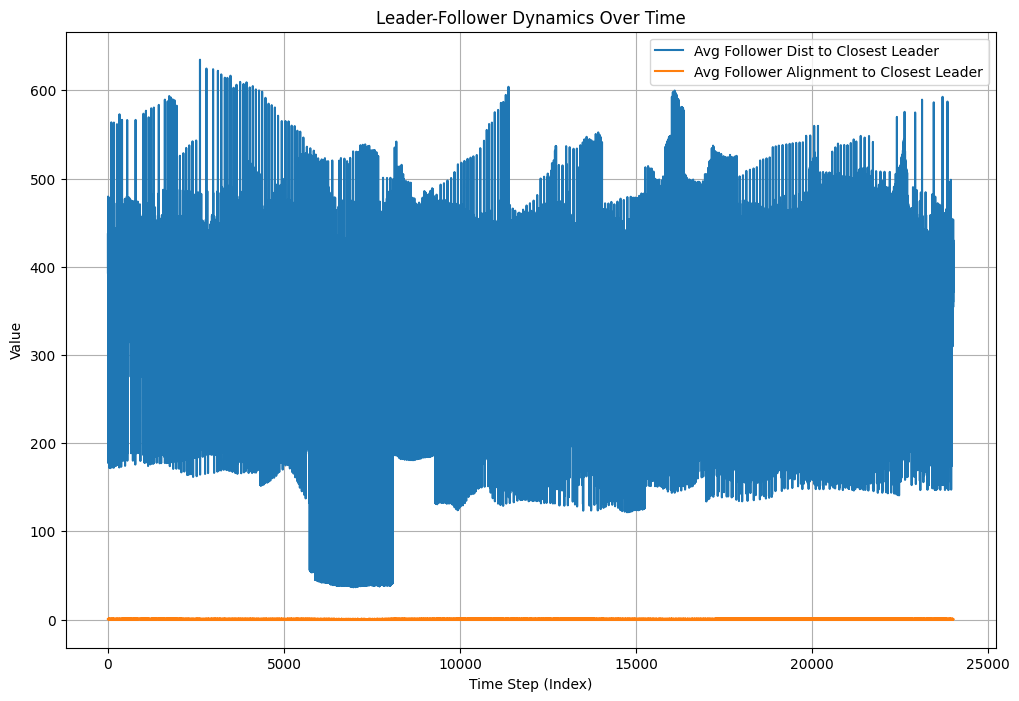

In [ ]:
# Assuming time is represented by the DataFrame index
plt.figure(figsize=(12, 8))

plt.plot(df_flocking.index, df_flocking['avg_follower_distance_to_closest_leader'], label='Avg Follower Dist to Closest Leader')
plt.plot(df_flocking.index, df_flocking['avg_follower_alignment_to_closest_leader'], label='Avg Follower Alignment to Closest Leader')

plt.title('Leader-Follower Dynamics Over Time')
plt.xlabel('Time Step (Index)') # Adjust label if you have a specific time column
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


Optimal number of components according to BIC (with new features): 14


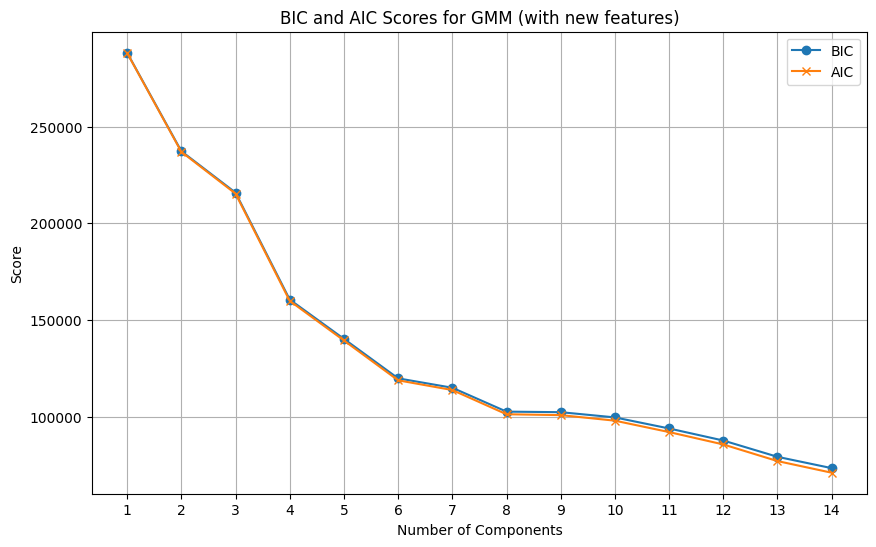


New cluster labels assigned based on GMM with expanded features.
   gmm_cluster_label_new
0                    5.0
1                    5.0
2                    5.0
3                    6.0
4                    5.0


In [ ]:
# --- Select the aggregate features for clustering ---
# Include the new features along with the previous ones
features_for_clustering = ['avg_velocity_magnitude', 'avg_distance_to_center',
                           'avg_alignment', 'avg_follower_distance_to_closest_leader',
                           'avg_follower_alignment_to_closest_leader']

# Create a new DataFrame with only the selected features and drop NaNs
clustering_data = df_flocking[features_for_clustering].dropna()

# --- Preprocess Data (Scale features) ---
scaler = StandardScaler()
X_scaled_new = scaler.fit_transform(clustering_data)

# --- Determine Range of Components to Test ---
n_components_range = range(1, 15) # Test from 1 to 14 components (adjust as needed)

# --- Fit GMMs and Calculate BIC/AIC ---
bic_new = []
aic_new = []
lowest_bic_new = np.inf
best_gmm_new = None

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_scaled_new)
    bic_new.append(gmm.bic(X_scaled_new))
    aic_new.append(gmm.aic(X_scaled_new))

    if bic_new[-1] < lowest_bic_new:
        lowest_bic_new = bic_new[-1]
        best_gmm_new = gmm

print(f"\nOptimal number of components according to BIC (with new features): {best_gmm_new.n_components}")

# --- Visualize BIC and AIC ---
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_new, marker='o', label='BIC')
plt.plot(n_components_range, aic_new, marker='x', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for GMM (with new features)')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# --- Assign new cluster labels to the DataFrame ---
# Predict clusters for the data that was used for clustering (after dropping NaNs)
new_cluster_labels = best_gmm_new.predict(X_scaled_new)

# Create a new column in the original df_flocking and fill it with NaN initially
df_flocking['gmm_cluster_label_new'] = np.nan

# Align the new cluster labels with the original DataFrame's index
# This is important because we dropped NaNs for clustering
df_flocking.loc[clustering_data.index, 'gmm_cluster_label_new'] = new_cluster_labels

print("\nNew cluster labels assigned based on GMM with expanded features.")
print(df_flocking[['gmm_cluster_label_new']].head())

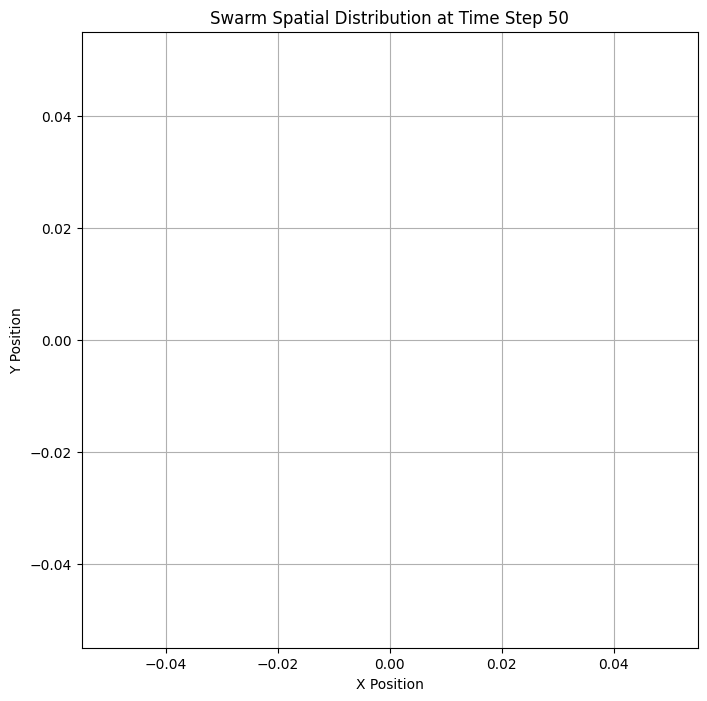

In [ ]:
# Choose a specific time step to visualize (e.g., the first time step, index 0)
time_step_to_visualize = 50

if time_step_to_visualize in df_flocking.index:
    # Get the data for the selected time step
    swarm_state = df_flocking.loc[time_step_to_visualize]

    # Extract x and y positions for all agents
    # Filter columns that start with 'x' and 'y' and end with digits
    x_pos_cols = [col for col in df_flocking.columns if col.startswith('x') and col[1:].isdigit()]
    y_pos_cols = [col for col in df_flocking.columns if col.startswith('y') and col[1:].isdigit()]

    agent_x_positions = swarm_state[x_pos_cols].dropna()
    agent_y_positions = swarm_state[y_pos_cols].dropna()

    # Ensure x and y positions are aligned (based on agent index)
    # We can create a temporary DataFrame to align them
    agent_positions_df = pd.DataFrame({'x': agent_x_positions, 'y': agent_y_positions}).dropna()


    plt.figure(figsize=(8, 8))
    plt.scatter(agent_positions_df['x'], agent_positions_df['y'], alpha=0.6, s=10) # s controls marker size
    plt.title(f'Swarm Spatial Distribution at Time Step {time_step_to_visualize}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to equal for a true spatial representation
    plt.show()

else:
    print(f"Time step {time_step_to_visualize} not found in the DataFrame index.")

# You could repeat this for different time steps to see how the spatial distribution evolves.

In [ ]:
#!pip install nose
#!pip install PyIF

from PyIF import te_compute
import pandas as pd
import numpy as np

# Assuming you have your time series data as NumPy arrays
time_series_x = df_flocking['avg_alignment'].dropna().values # Example source variable
time_series_y = df_flocking['avg_velocity_magnitude'].dropna().values # Example target variable

# Ensure the time series have the same length
min_len_ts = min(len(time_series_x), len(time_series_y))
time_series_x = time_series_x[:min_len_ts]
time_series_y = time_series_y[:min_len_ts]

if len(time_series_x) > 1: # Need enough data points
    try:
        # Try calling the function directly from the module.
        # The actual function name might be 'transfer_entropy', 'calc_te', etc.
        # You might need to experiment with these names or consult PyIF documentation.

        # Let's try some common names:
        if hasattr(te_compute, 'transfer_entropy'):
            te_x_to_y = te_compute.transfer_entropy(time_series_x, time_series_y)
            te_y_to_x = te_compute.transfer_entropy(time_series_y, time_series_x)
            print(f"\nTransfer Entropy (Avg Alignment -> Avg Velocity Magnitude): {te_x_to_y}")
            print(f"Transfer Entropy (Avg Velocity Magnitude -> Avg Alignment): {te_y_to_x}")

        elif hasattr(te_compute, 'calc_te'):
            te_x_to_y = te_compute.calc_te(time_series_x, time_series_y)
            te_y_to_x = te_compute.calc_te(time_series_y, time_series_x)
            print(f"\nTransfer Entropy (Avg Alignment -> Avg Velocity Magnitude): {te_x_to_y}")
            print(f"Transfer Entropy (Avg Velocity Magnitude -> Avg Alignment): {te_y_to_x}")

        # Add other possible function names here if needed

        else:
            print("Could not find a suitable transfer entropy calculation function in PyIF.te_compute.")
            print("Please consult the PyIF documentation to find the correct function name and usage.")


    except Exception as e:
        print(f"Could not calculate Transfer Entropy using PyIF: {e}")
        print("Ensure you have enough data points and consult PyIF documentation for parameters.")

else:
    print("\nNot enough data points to calculate Transfer Entropy.")

Could not find a suitable transfer entropy calculation function in PyIF.te_compute.
Please consult the PyIF documentation to find the correct function name and usage.


## Exploring Graph-based measures.

Exploring Graph-based measures like degree centrality is a very relevant and powerful approach for understanding leadership influence and information flow in a swarm or group of agents.

This approach involves representing the swarm as a network (a graph), where:

Nodes represent individual agents.
Edges represent the relationship or interaction between agents. This relationship could be based on:

- Proximity: Agents within a certain distance of each other are connected.

- Visibility: Agents that are within each other's field of view are connected.
Interaction rules: Connections could be based on how agents interact according to the simulation rules (e.g., who influences whom).

Once we have a graph representation for each time step (or for snapshots of the swarm's evolution), you can use network analysis metrics to quantify leadership influence.

Degree Centrality is one of the simplest but often insightful centrality measures.

Definition: The degree of a node is the number of edges connected to it.
Interpretation in a Swarm Context:

- In-Degree Centrality: If edges represent "influence received," a high in-degree means an agent is being influenced by many other agents.

- Out-Degree Centrality: If edges represent "influence exerted," a high out-degree means an agent is influencing many other agents.

- Total Degree Centrality: The total number of connections an agent has. In a proximity-based graph, this indicates how many neighbors an agent has.
Steps to Analyze Leadership Influence using

- Degree Centrality:
Define the Graph (Network) based on Agent Relationships: You need to decide what constitutes an edge between agents. Proximity is a common and often effective way to start.

Choose a distance threshold: Agents closer than this threshold are considered connected.
Iterate through time steps: For each time step, create a graph based on the agent positions.
Create the Graph for Each Time Step:

You can use a library like networkx to create and analyze graphs in Python.
For each time step, get the positions of all agents.

Iterate through all pairs of agents and add an edge between them if the distance between them is below your chosen threshold.
Calculate Degree Centrality:

Use networkx functions to calculate the degree (or in/out degree for directed graphs) of each agent in the graph for each time step.

Analyze Degree Centrality Measures:
Track individual agent centrality over time: See if certain agents consistently have high centrality (potential leaders).
Calculate average centrality measures for the swarm: See how the overall connectivity changes.

Relate centrality to other swarm metrics: Do states with high average alignment correspond to different connectivity patterns?

Identify potential leaders: Agents with consistently high out-degree (if using a directed influence graph) or high total degree (in a proximity graph) might be acting as leaders.

In [2]:
# Install networkx if you haven't already
#!pip install networkx

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Define parameters ---
distance_threshold = 50.0  # Example threshold: agents within 50 units are connected (adjust based on your simulation scale)

# --- Initialize lists to store centrality measures over time ---
avg_degree_centrality_over_time = []
# You could also store individual agent centralities if needed

# --- Iterate through each time step ---
# Assume agent positions are in columns like 'x1', 'y1', 'x2', 'y2', etc.
x_pos_cols = [col for col in df_flocking.columns if col.startswith('x') and col[1:].isdigit()]
y_pos_cols = [col for col in df_flocking.columns if col.startswith('y') and col[1:].isdigit()]

# Get the agent indices
agent_indices = [int(col[1:]) for col in x_pos_cols] # Assuming x_pos_cols and y_pos_cols are aligned

# Create a list of (agent_index, position_columns) tuples
agent_position_info = [(i, f'x{i}', f'y{i}') for i in agent_indices]


for index, row in df_flocking.iterrows():
    # Create an empty graph for the current time step
    G = nx.Graph() # Use nx.DiGraph() for a directed graph if defining directed influence

    # Add nodes to the graph (agents)
    G.add_nodes_from(agent_indices)

    # Add edges based on proximity
    for i, xi_col, yi_col in agent_position_info:
        xi, yi = row[xi_col], row[yi_col]
        if pd.isna(xi) or pd.isna(yi):
            continue # Skip if agent position is missing

        for j, xj_col, yj_col in agent_position_info:
            if i != j: # Don't connect an agent to itself
                xj, yj = row[xj_col], row[yj_col]
                if pd.isna(xj) or pd.isna(yj):
                    continue # Skip if other agent position is missing

                distance = np.sqrt((xi - xj)**2 + (yi - yj)**2)

                if distance < distance_threshold:
                    G.add_edge(i, j) # Add an edge between agent i and agent j

    # Calculate Degree Centrality for the current time step's graph
    degree_centrality = nx.degree_centrality(G)

    # Store the average degree centrality for this time step
    if degree_centrality:
        avg_degree = np.mean(list(degree_centrality.values()))
        avg_degree_centrality_over_time.append(avg_degree)
    else:
        avg_degree_centrality_over_time.append(0) # Or np.nan if no agents or no connections

# Add the average degree centrality as a new column to the DataFrame
df_flocking['avg_degree_centrality'] = pd.Series(avg_degree_centrality_over_time, index=df_flocking.index)

print("\nAverage Degree Centrality over time calculated.")
print(df_flocking[['avg_degree_centrality']].head())

# --- Visualize Average Degree Centrality Over Time ---
plt.figure(figsize=(12, 6))
plt.plot(df_flocking.index, df_flocking['avg_degree_centrality'])
plt.title('Average Swarm Degree Centrality Over Time')
plt.xlabel('Time Step (Index)')
plt.ylabel('Average Degree Centrality')
plt.grid(True)
plt.show()

NameError: name 'df_flocking' is not defined